In [14]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Seaborn
import seaborn as sns
sns.set(style="white", color_codes=True)
sns.set_context(rc={"font.family":'sans',"font.size":24,"axes.titlesize":24,"axes.labelsize":24,'figure.figsize':(20,20)})

In [15]:
thr1 = pd.read_csv("thrvscurve1m.txt")
thr2 = pd.read_csv("thrvscurve2m.txt")
thr3 = pd.read_csv("thrvscurve3m.txt")
thr4 = pd.read_csv("thrvscurve4m.txt")
thr5 = pd.read_csv("thrvscurve5m.txt")
thr6 = pd.read_csv("thrvscurve6m.txt")
thr7 = pd.read_csv("thrvscurve7m.txt")
thr8 = pd.read_csv("thrvscurve8m.txt")
thr9 = pd.read_csv("thrvscurve9m.txt")
thr10 = pd.read_csv("thrvscurve10m.txt")

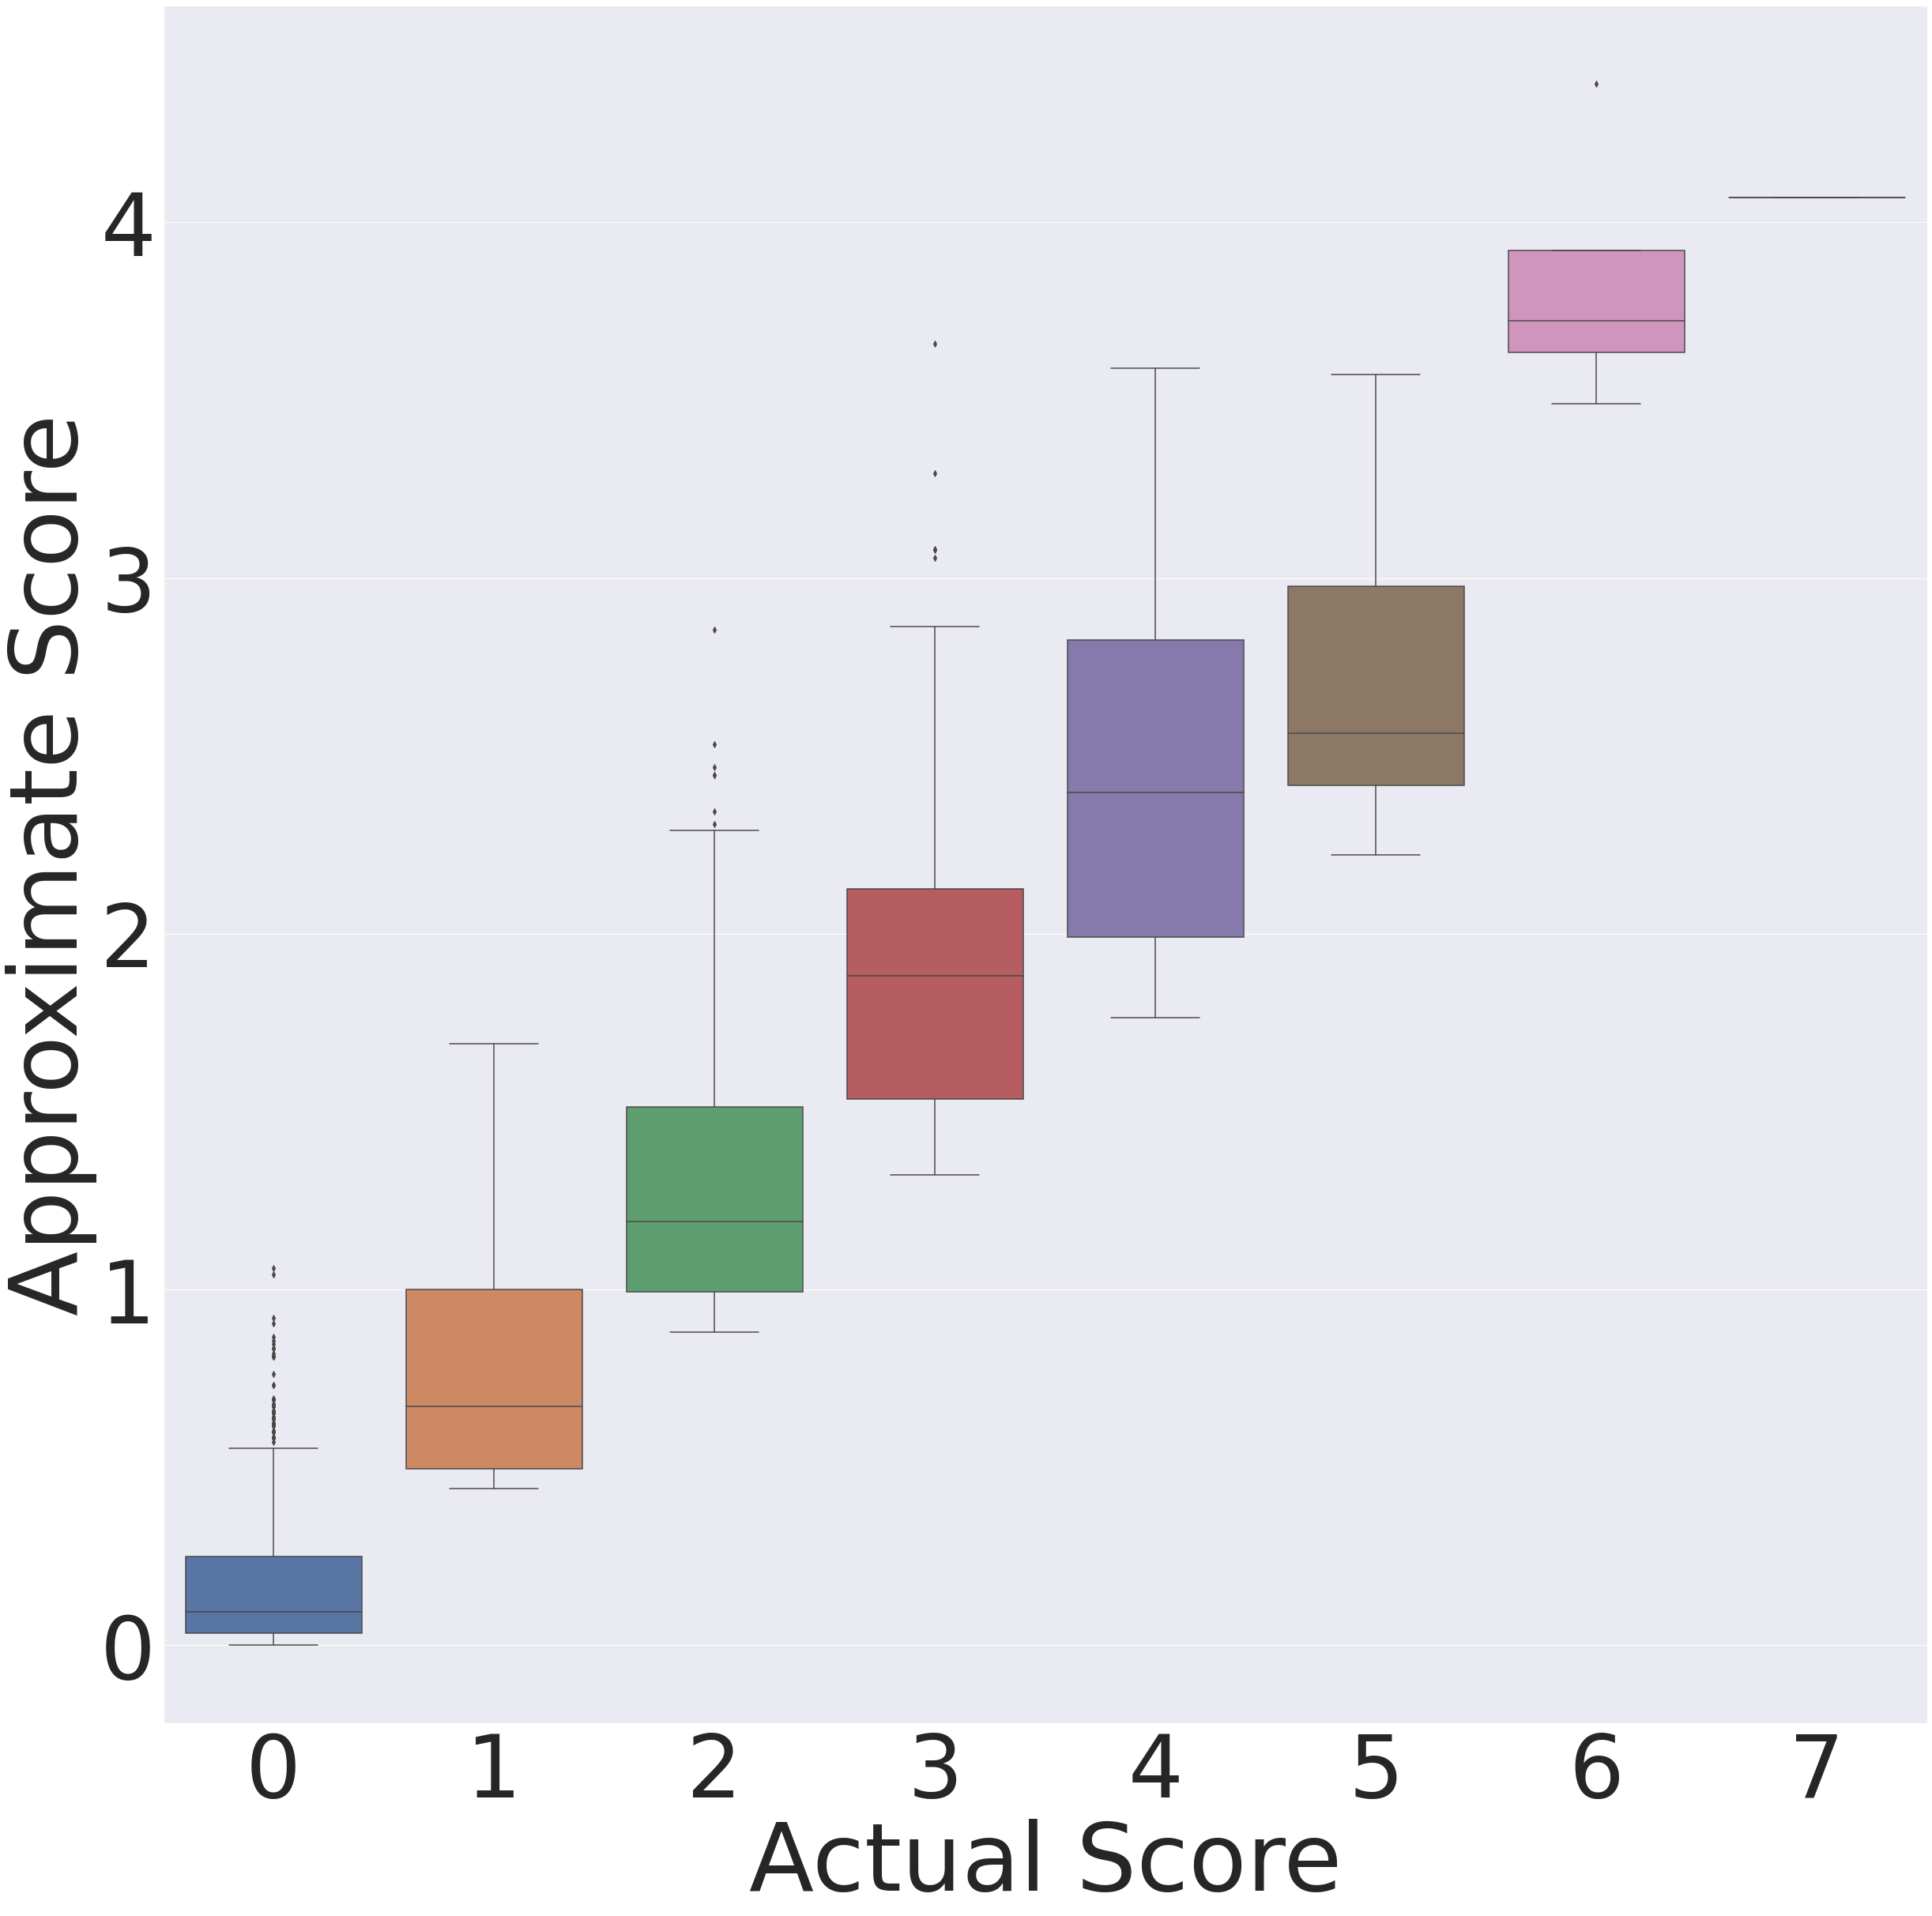

In [16]:
plt.figure(figsize=(40,40))
sns.set_context("notebook", font_scale=2.5, rc={"lines.linewidth": 1})
sns.set(font_scale=10)
ax = sns.boxplot(x="Threshold", y=" Curve", data=thr1)
ax.set(xlabel='Actual Score', ylabel='Approximate Score')
plt.show()

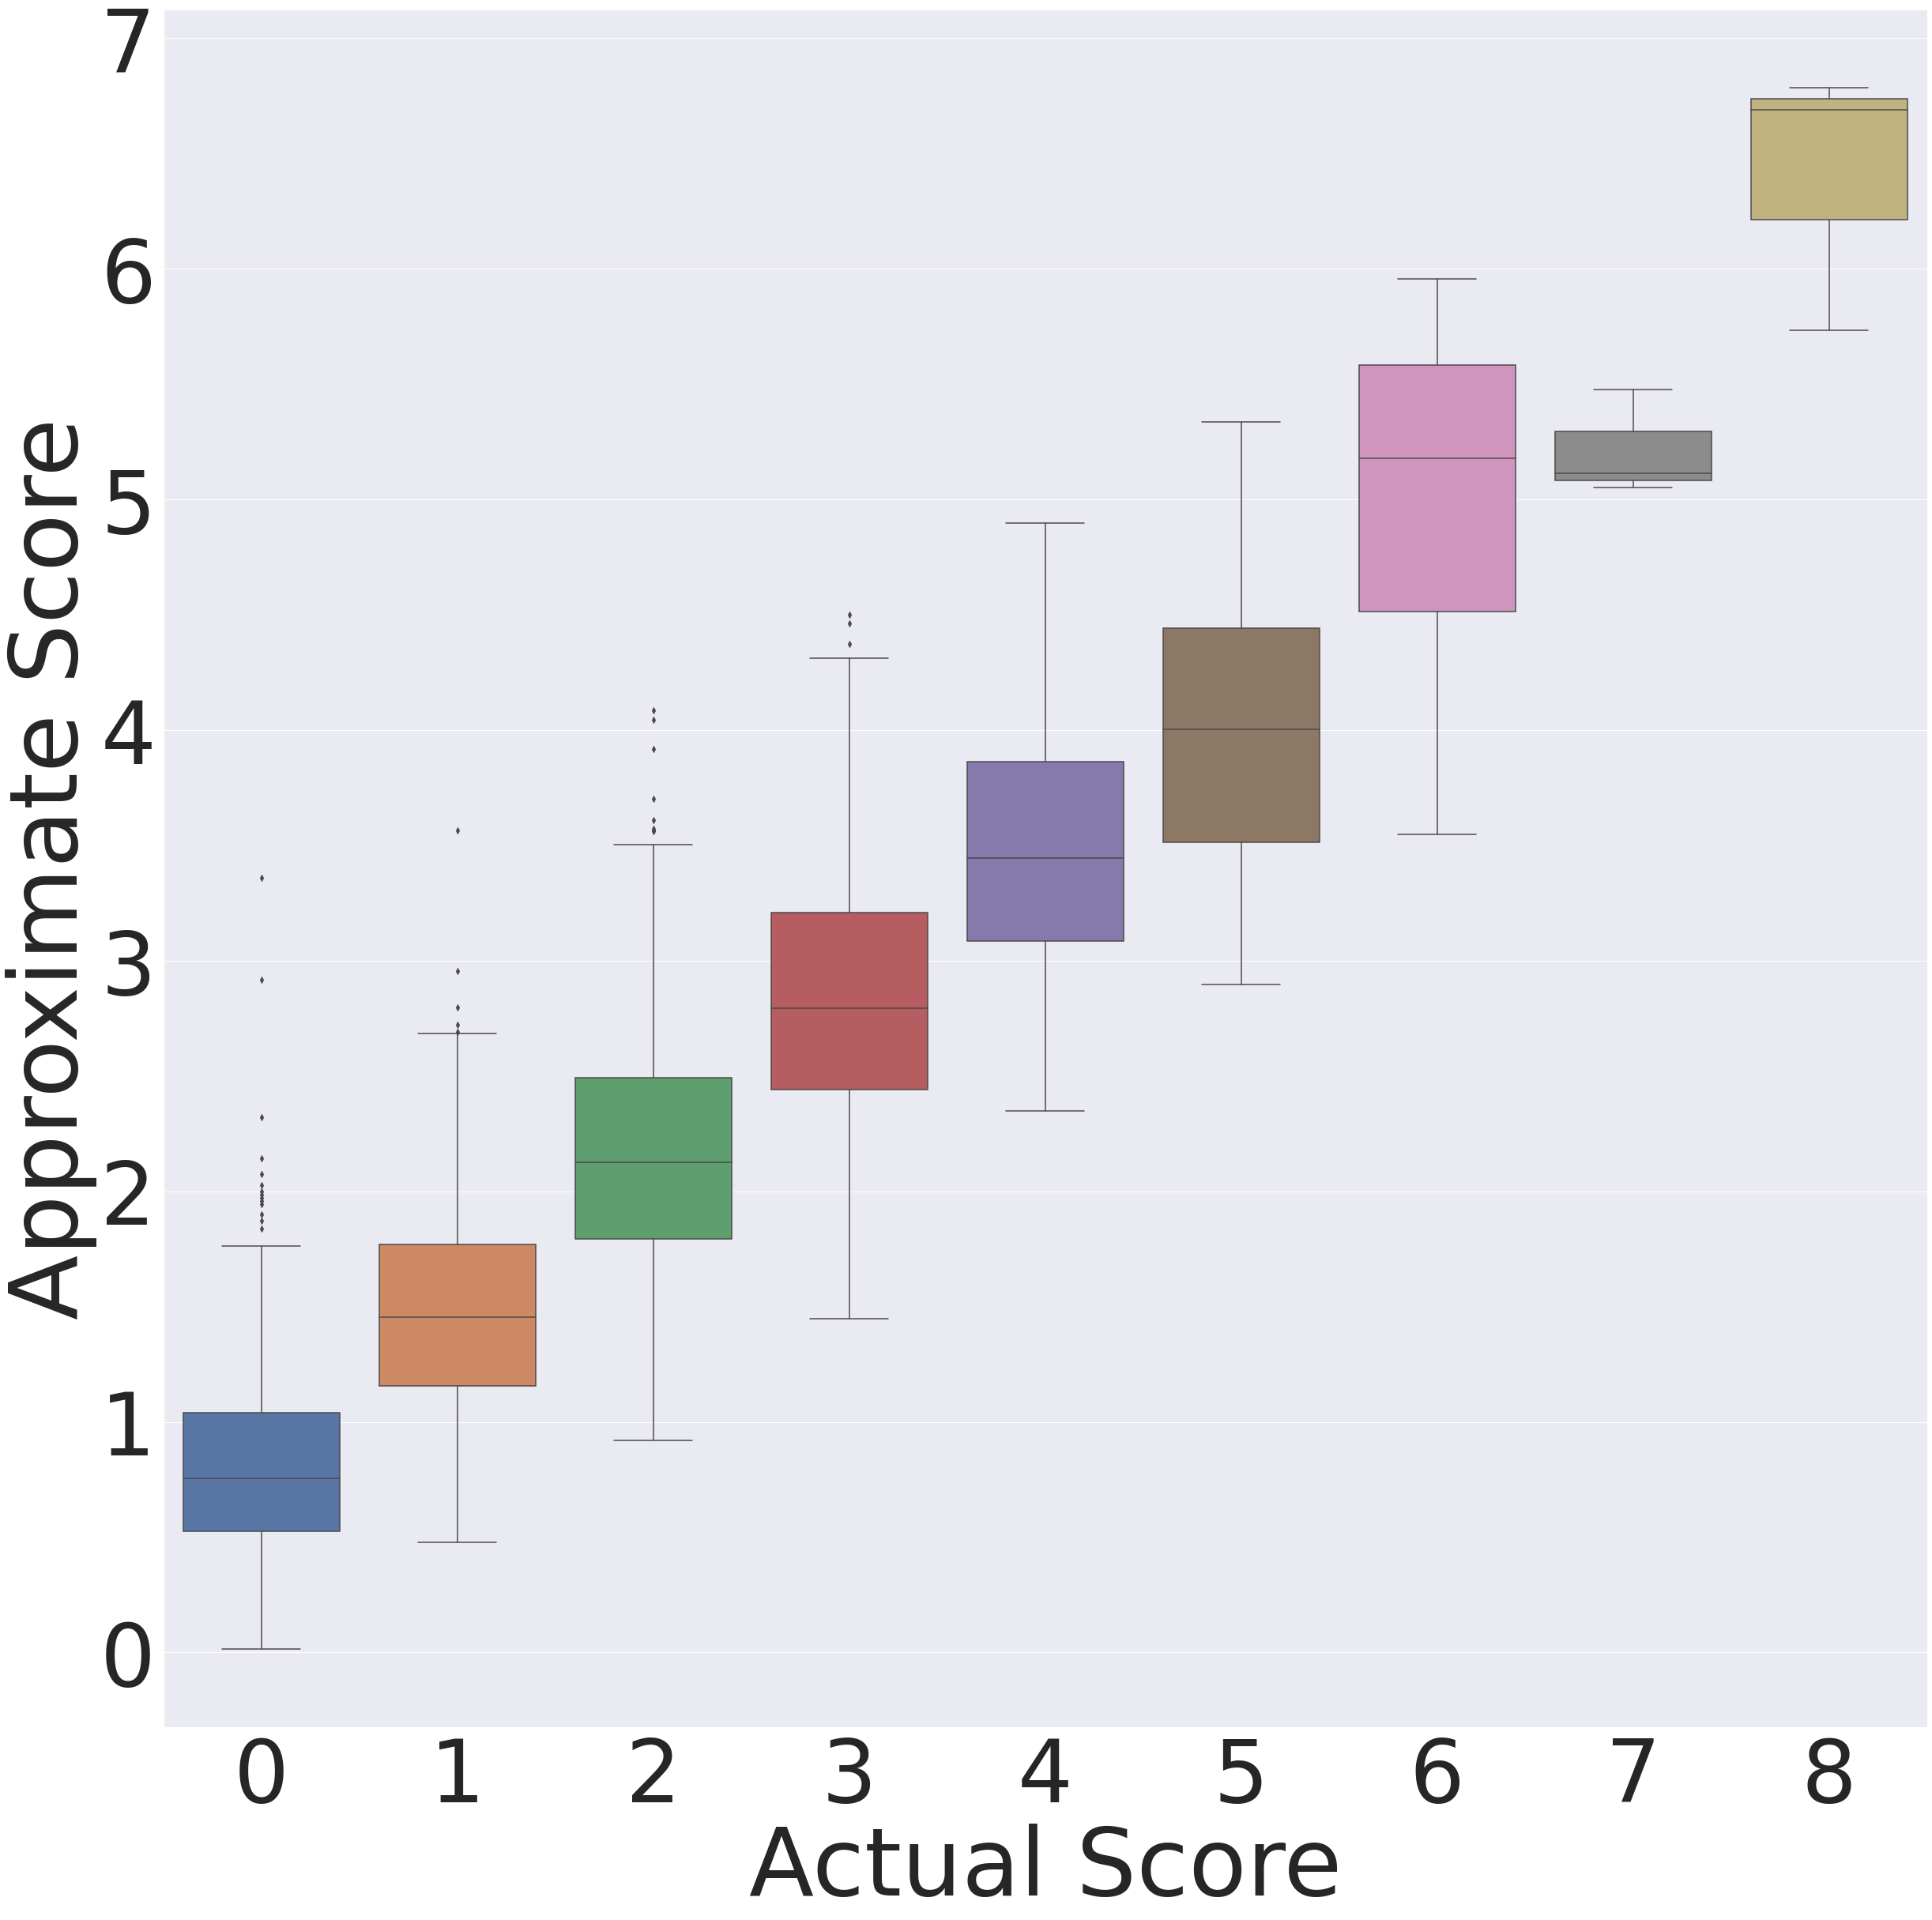

In [17]:
plt.figure(figsize=(40,40))
sns.set_context("notebook", font_scale=2.5, rc={"lines.linewidth": 1})
sns.set(font_scale=10)
ax = sns.boxplot(x="Threshold", y=" Curve", data=thr2)
ax.set(xlabel='Actual Score', ylabel='Approximate Score')
plt.show()

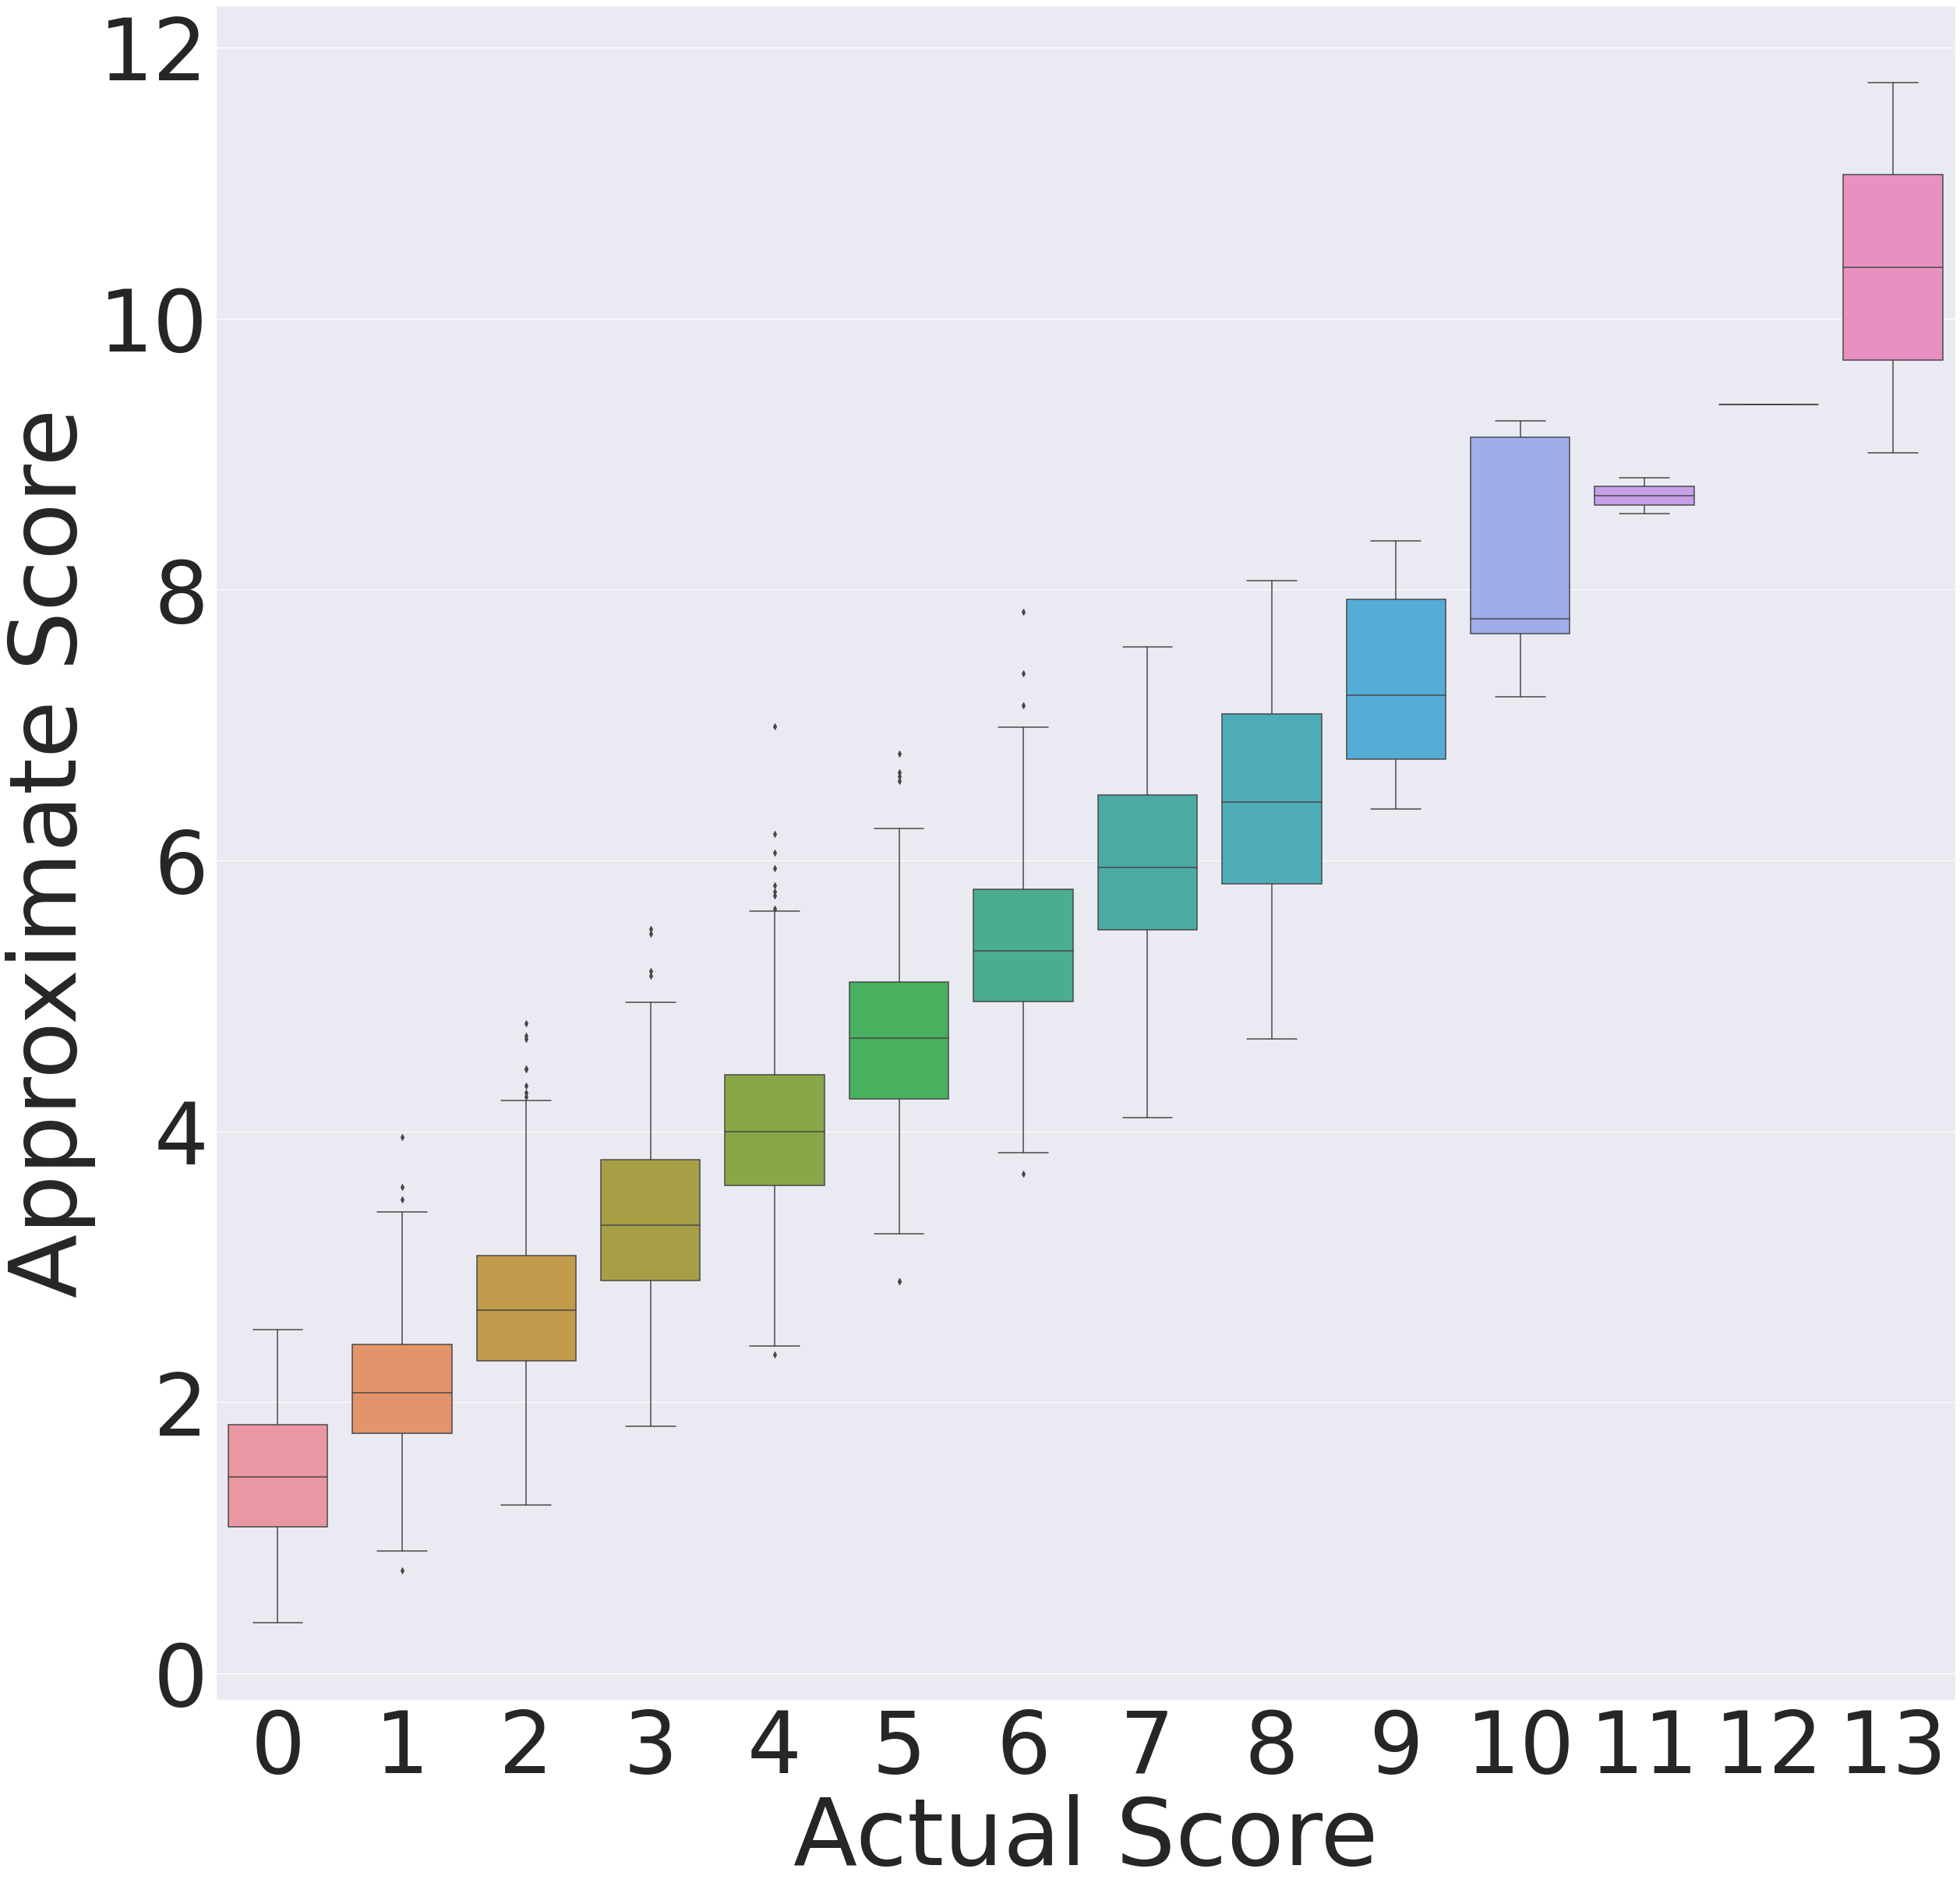

In [18]:
plt.figure(figsize=(40,40))
sns.set_context("notebook", font_scale=2.5, rc={"lines.linewidth": 1})
sns.set(font_scale=10)
ax = sns.boxplot(x="Threshold", y=" Curve", data=thr3)
ax.set(xlabel='Actual Score', ylabel='Approximate Score')
plt.show()

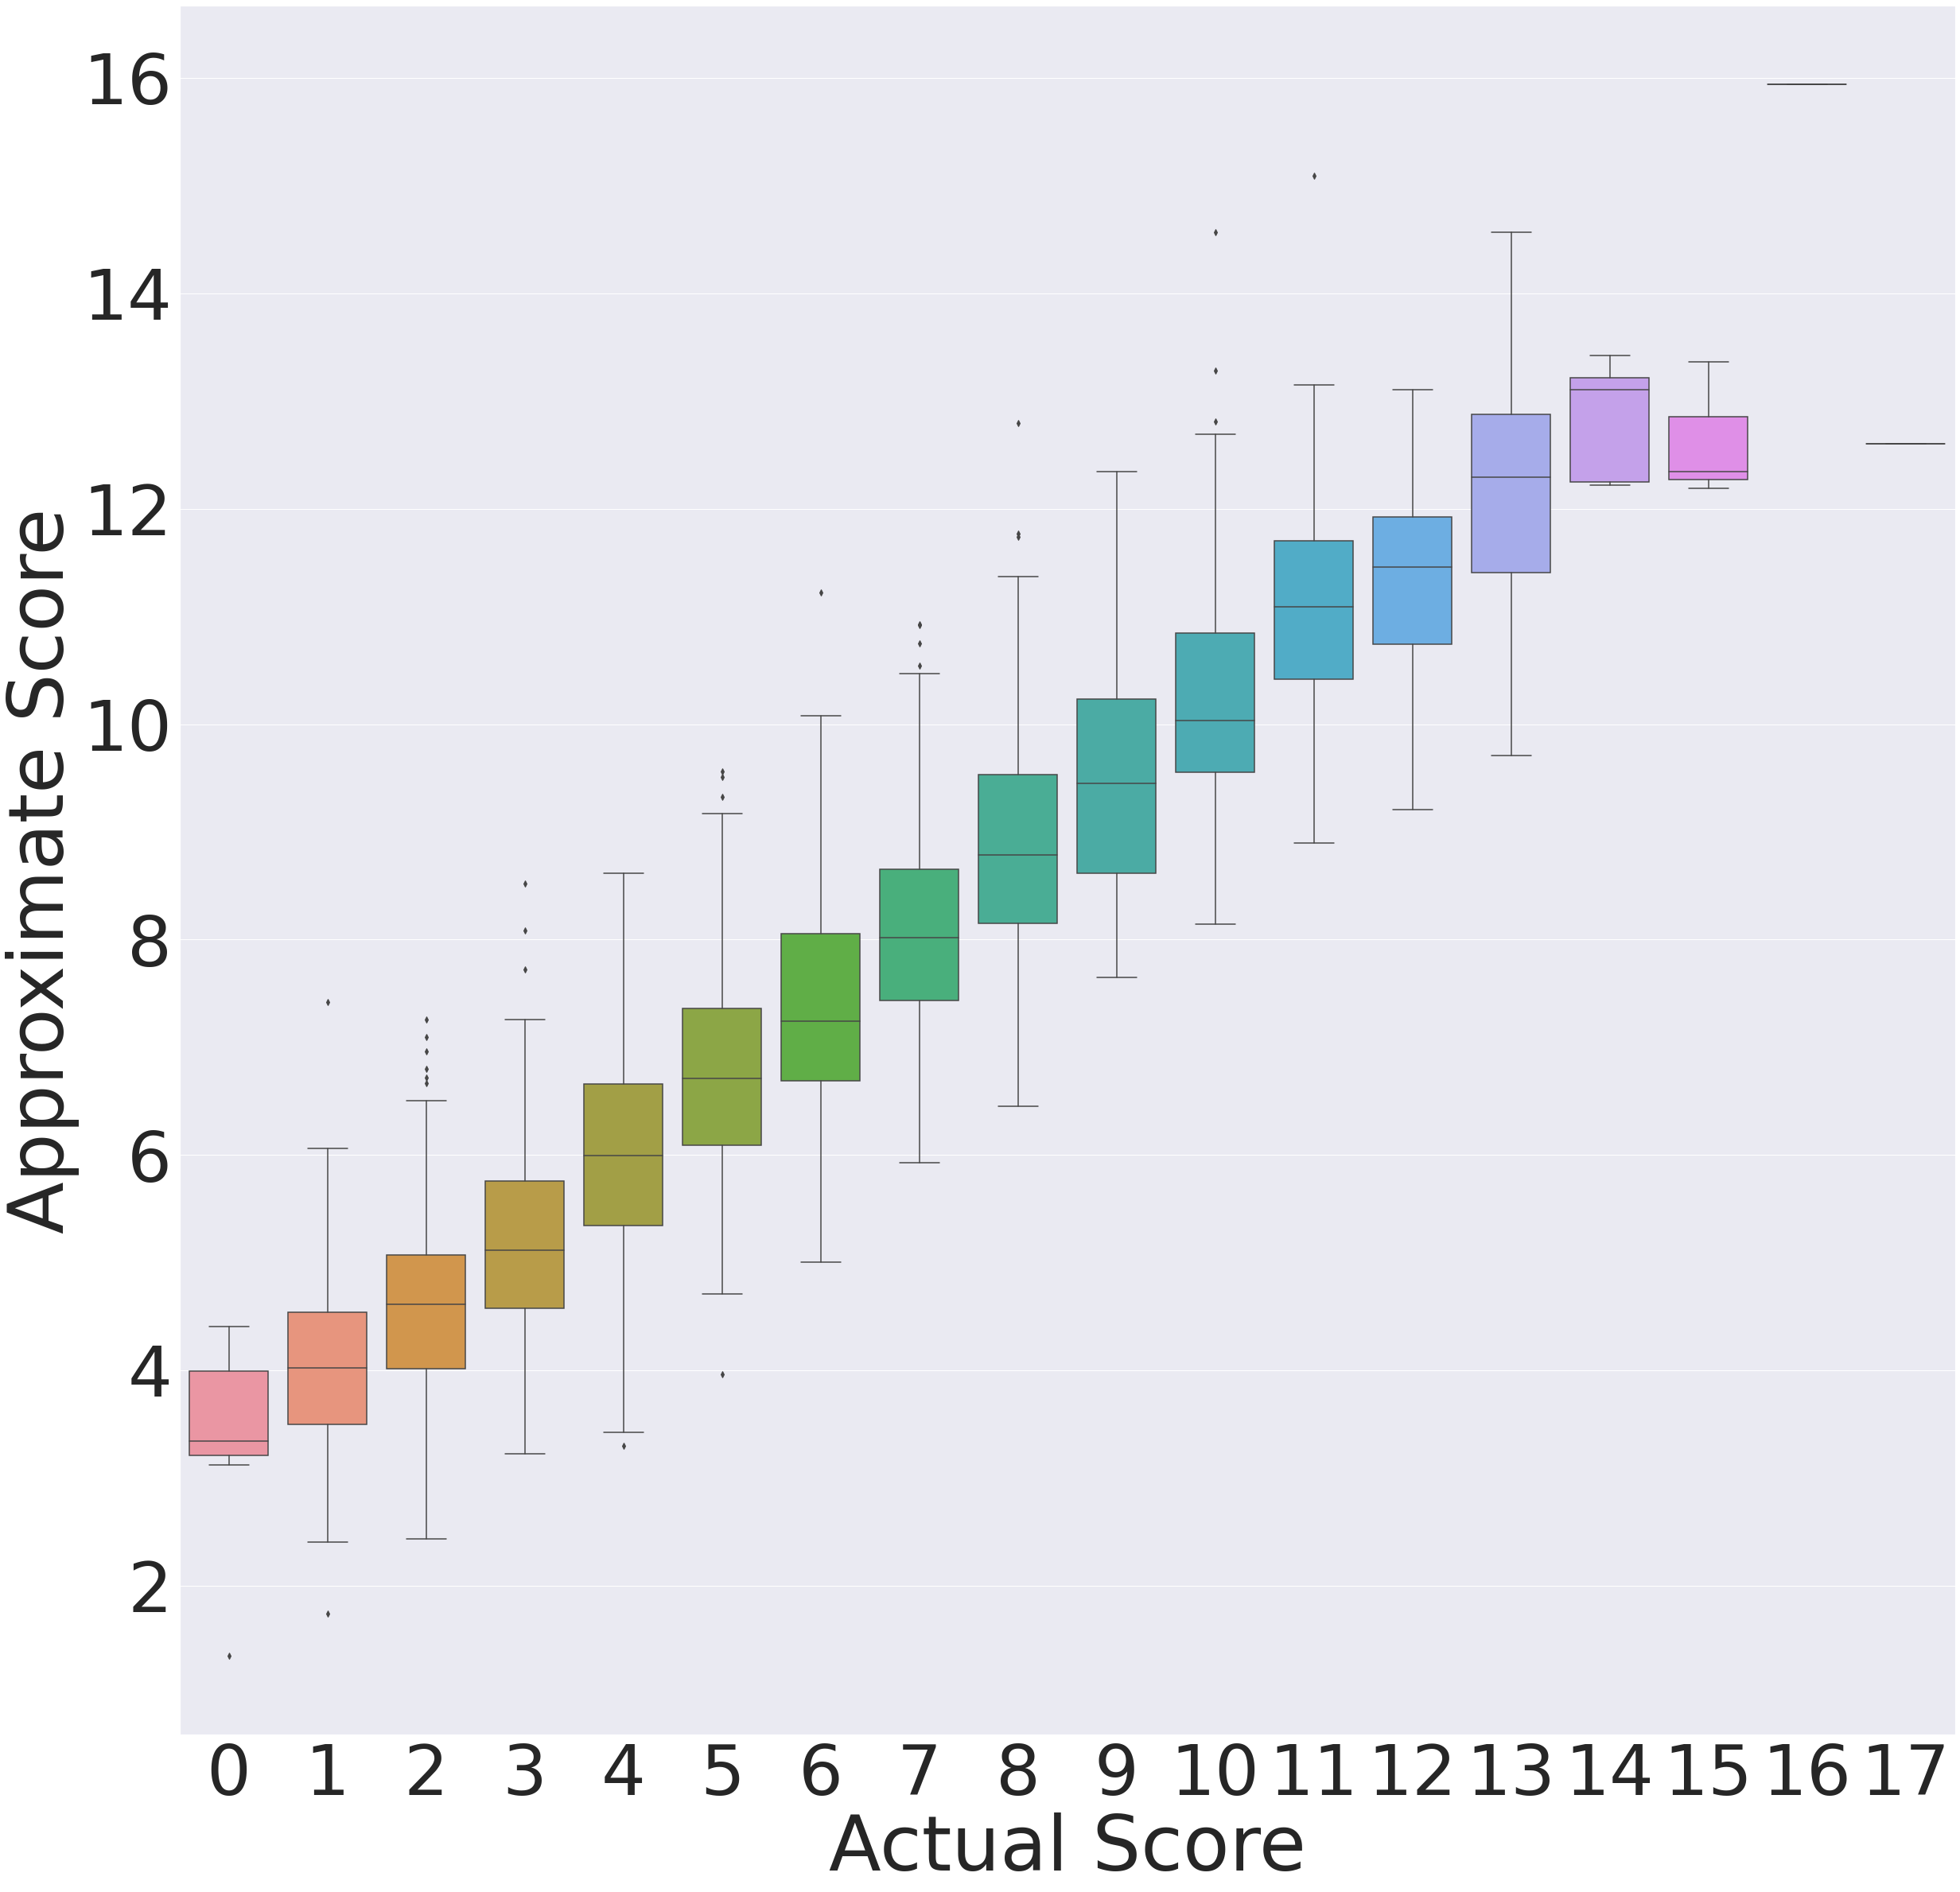

In [19]:
plt.figure(figsize=(40,40))
sns.set_context("notebook", font_scale=2.5, rc={"lines.linewidth": 1})
sns.set(font_scale=8)
ax = sns.boxplot(x="Threshold", y=" Curve", data=thr4)
ax.set(xlabel='Actual Score', ylabel='Approximate Score')
plt.show()

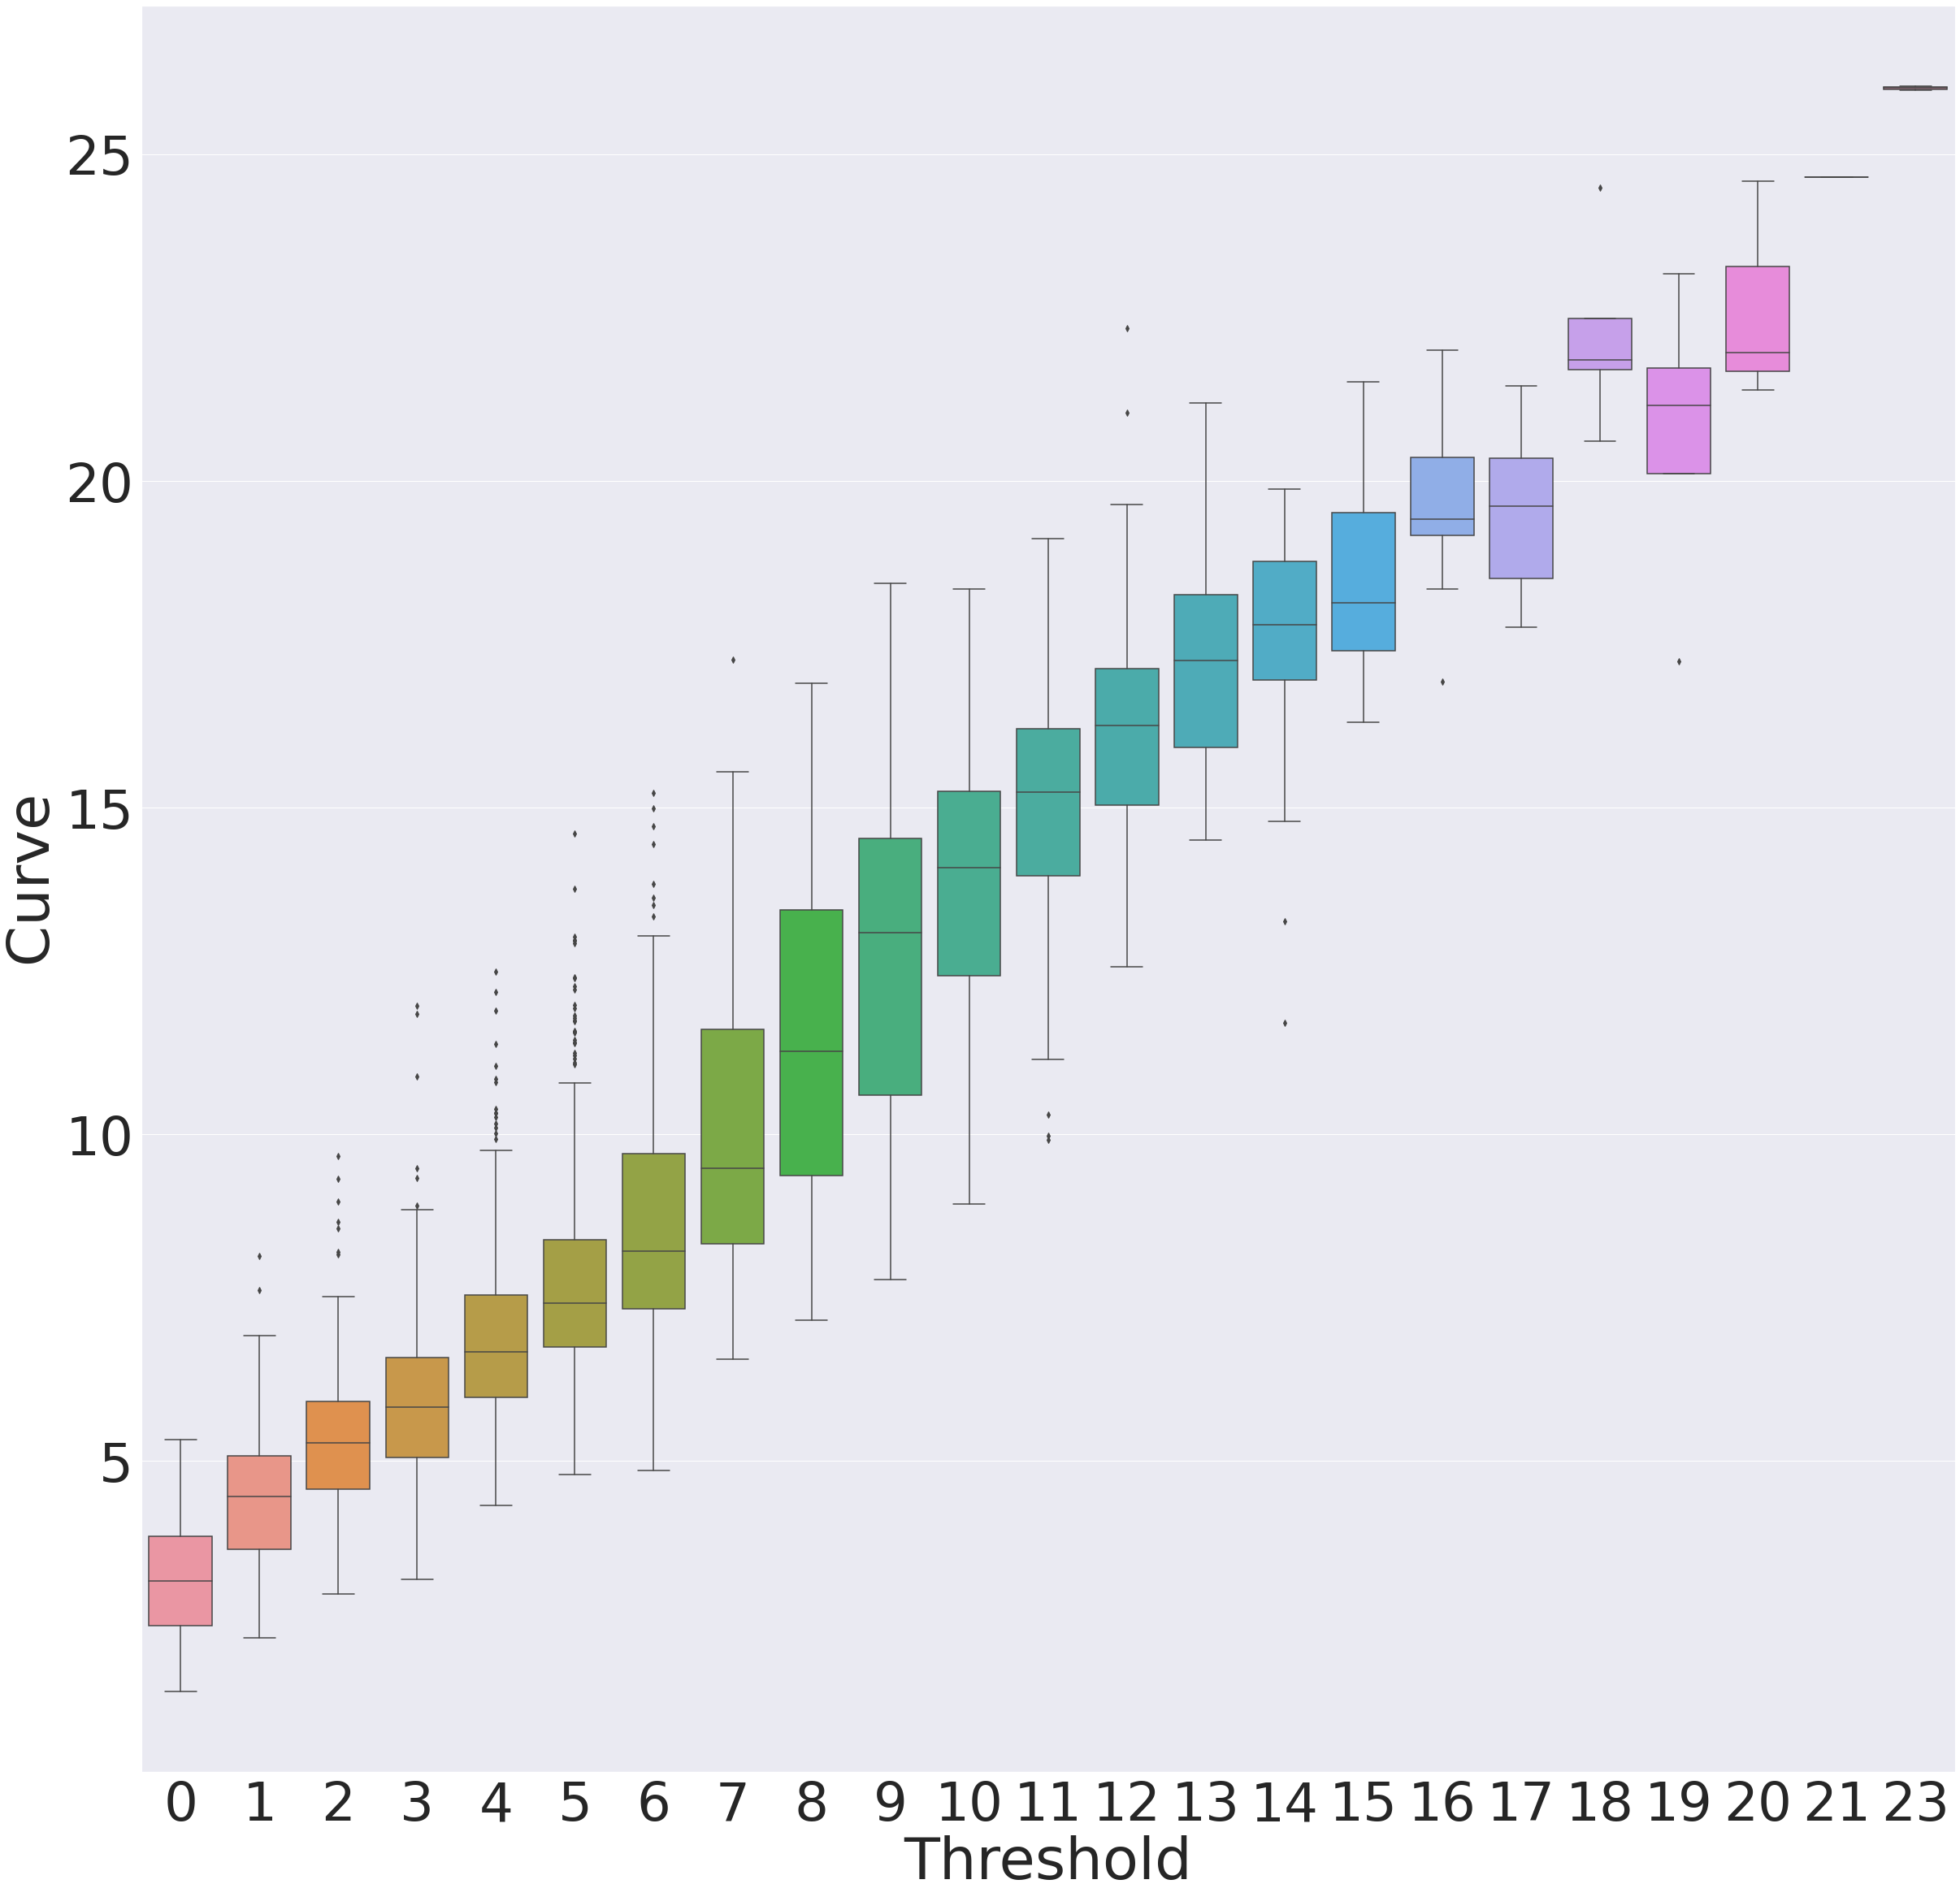

In [20]:
plt.figure(figsize=(40,40))
sns.set_context("notebook", font_scale=2.5, rc={"lines.linewidth": 1})
sns.set(font_scale=6)
ax = sns.boxplot(x="Threshold", y=" Curve", data=thr5)

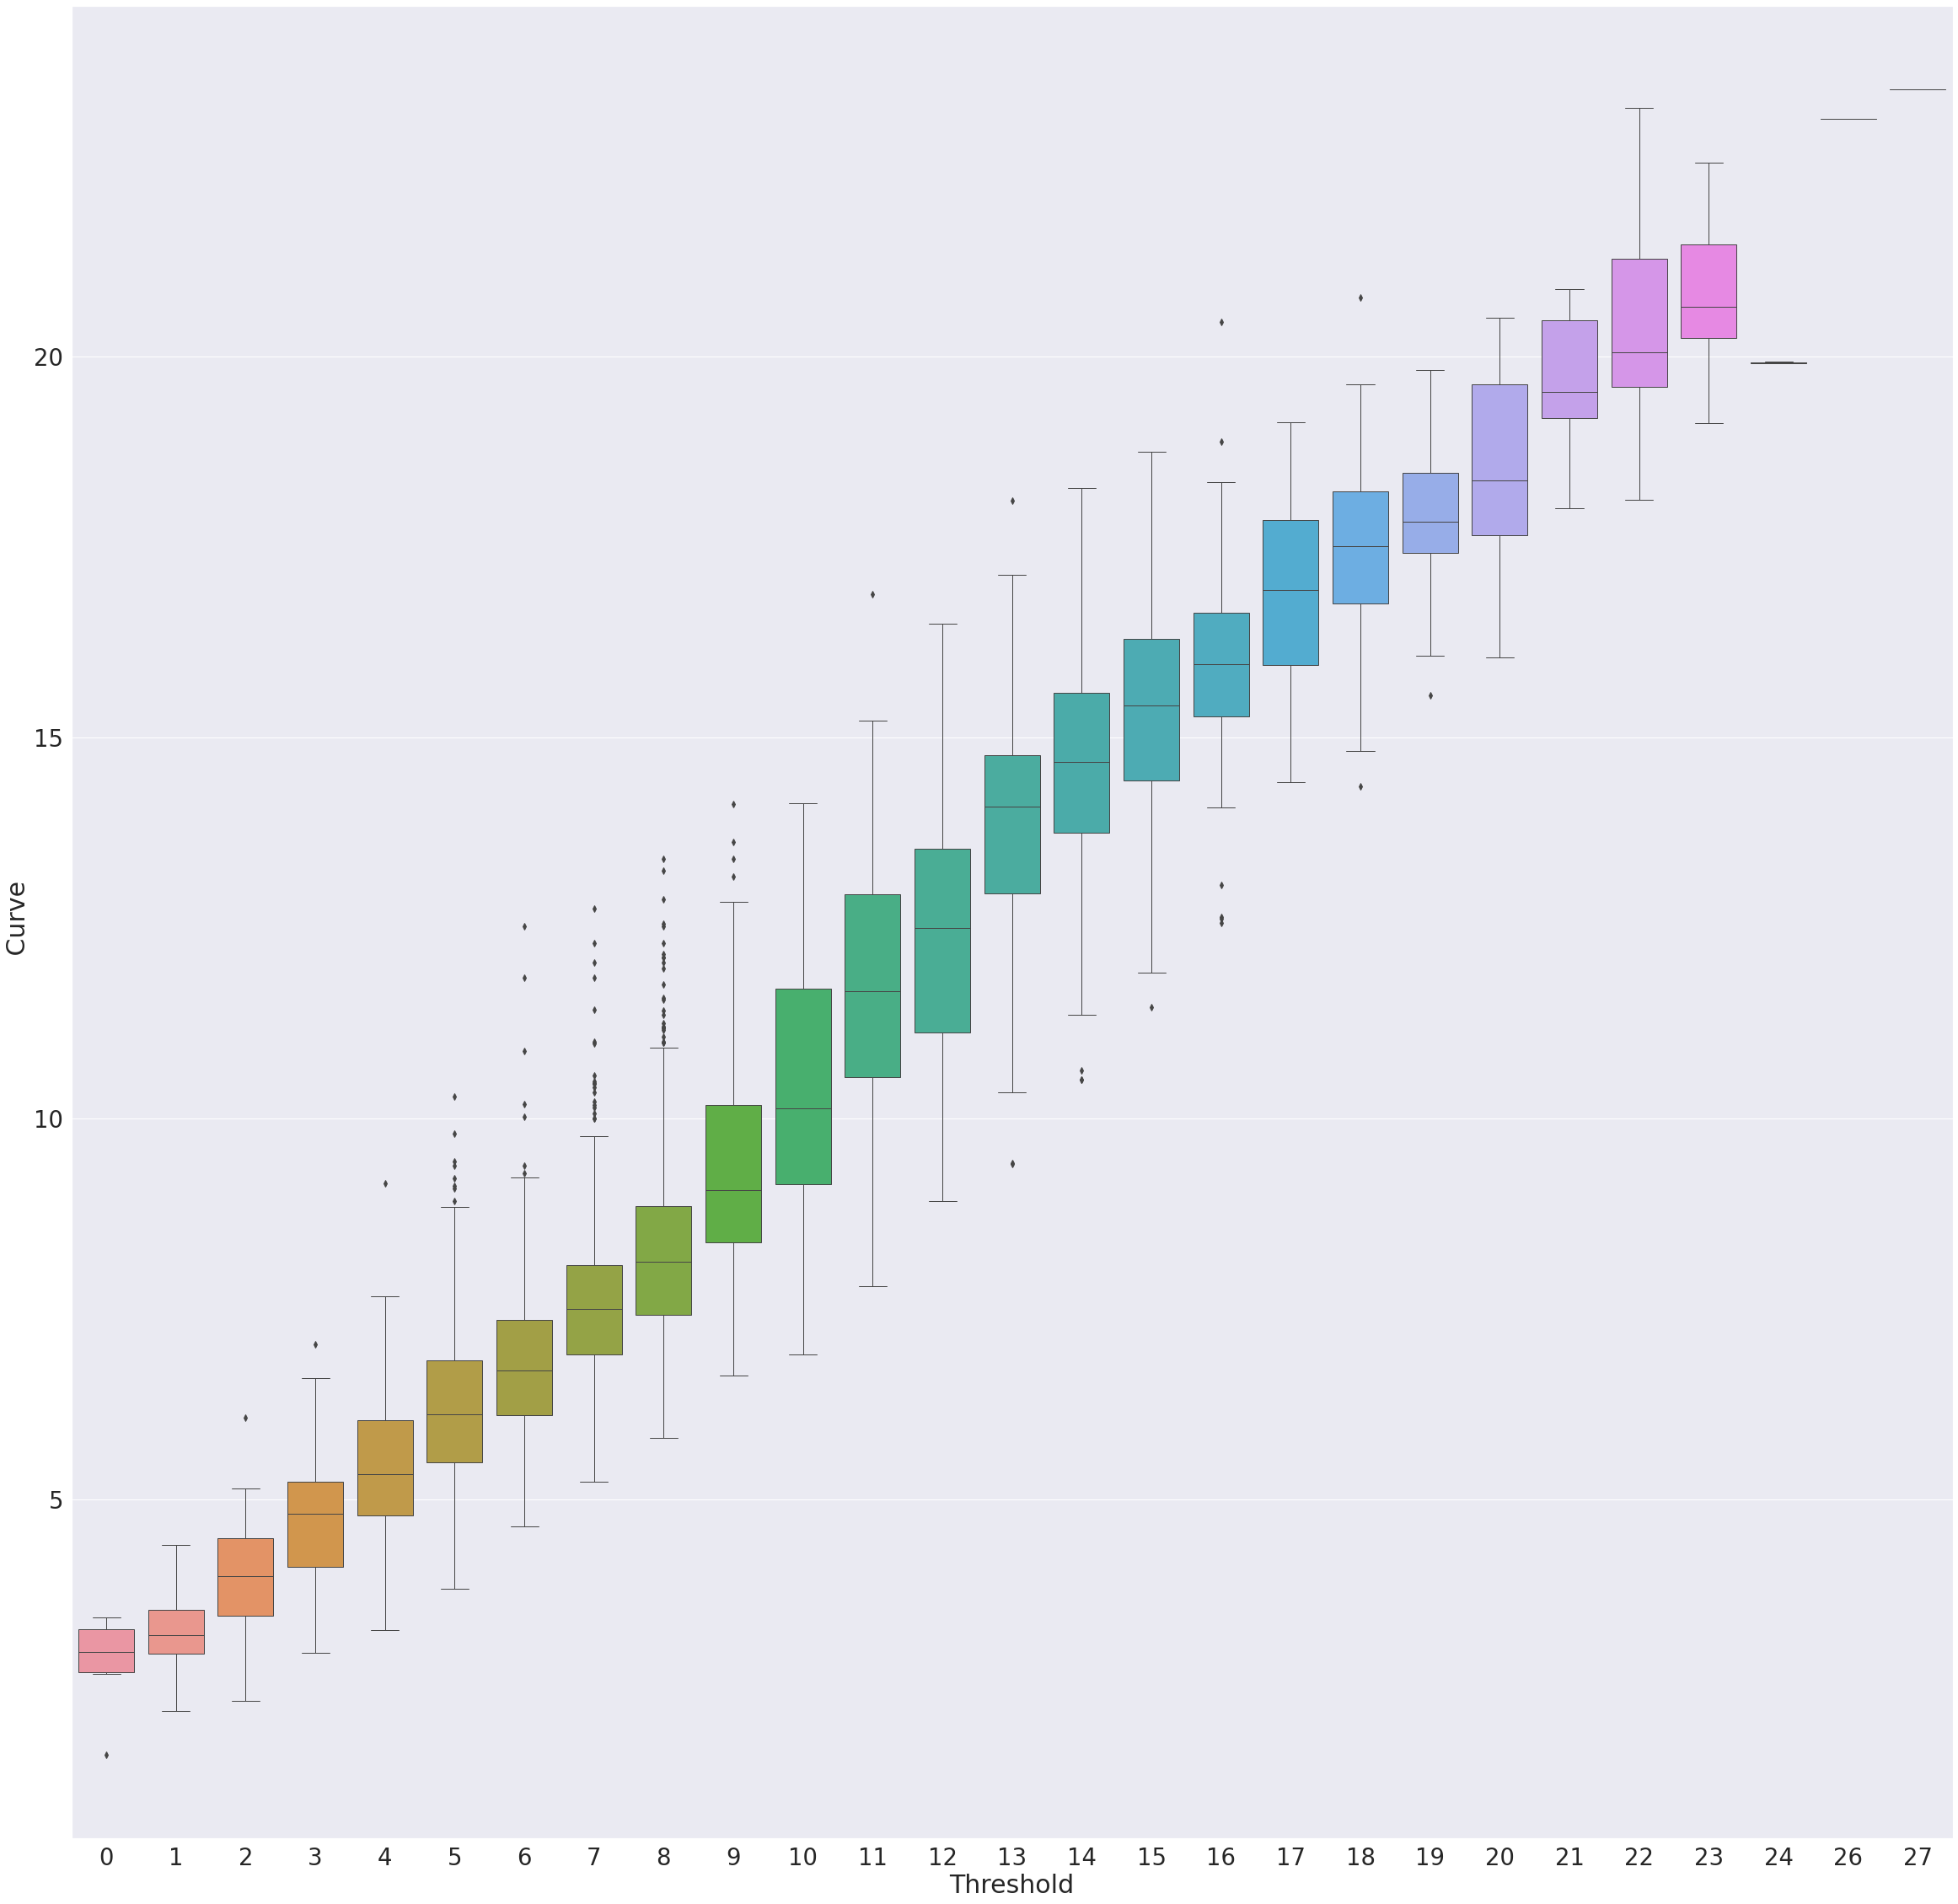

In [21]:
plt.figure(figsize=(40,40))
sns.set_context("notebook", font_scale=2.5, rc={"lines.linewidth": 1})
ax = sns.boxplot(x="Threshold", y=" Curve", data=thr6)

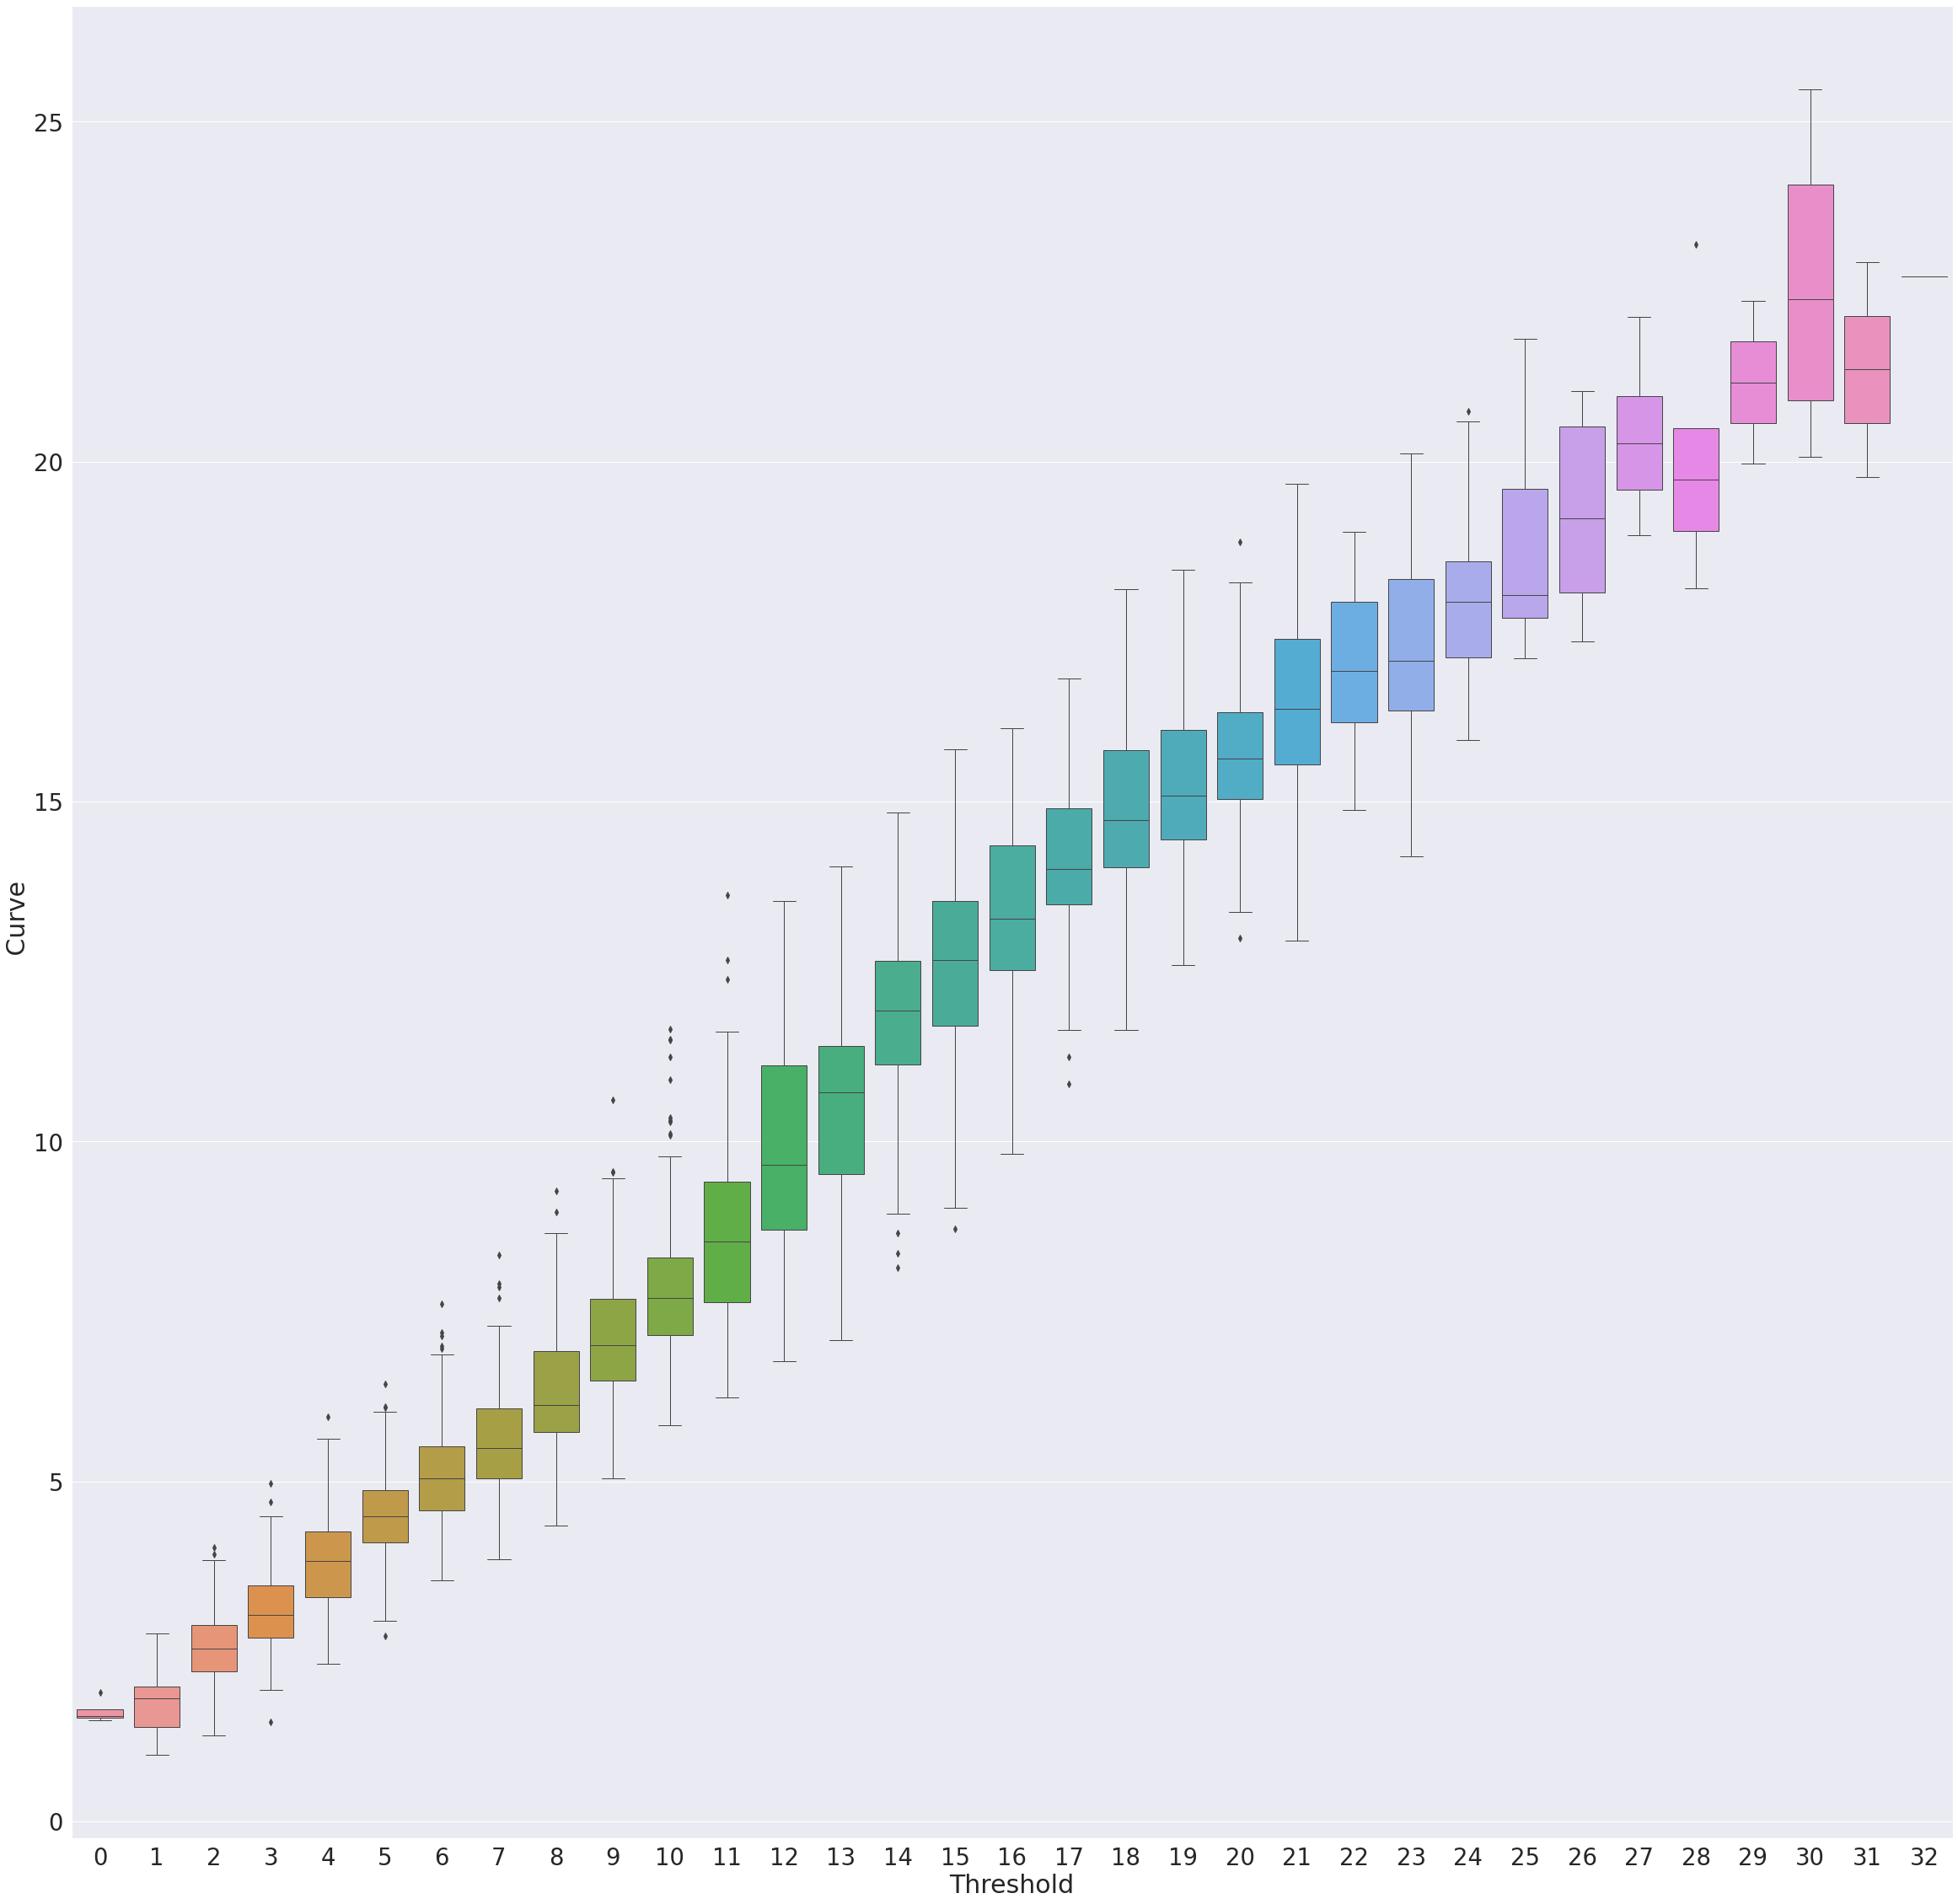

In [22]:
plt.figure(figsize=(40,40))
sns.set_context("notebook", font_scale=2.5, rc={"lines.linewidth": 1})
ax = sns.boxplot(x="Threshold", y=" Curve", data=thr7)

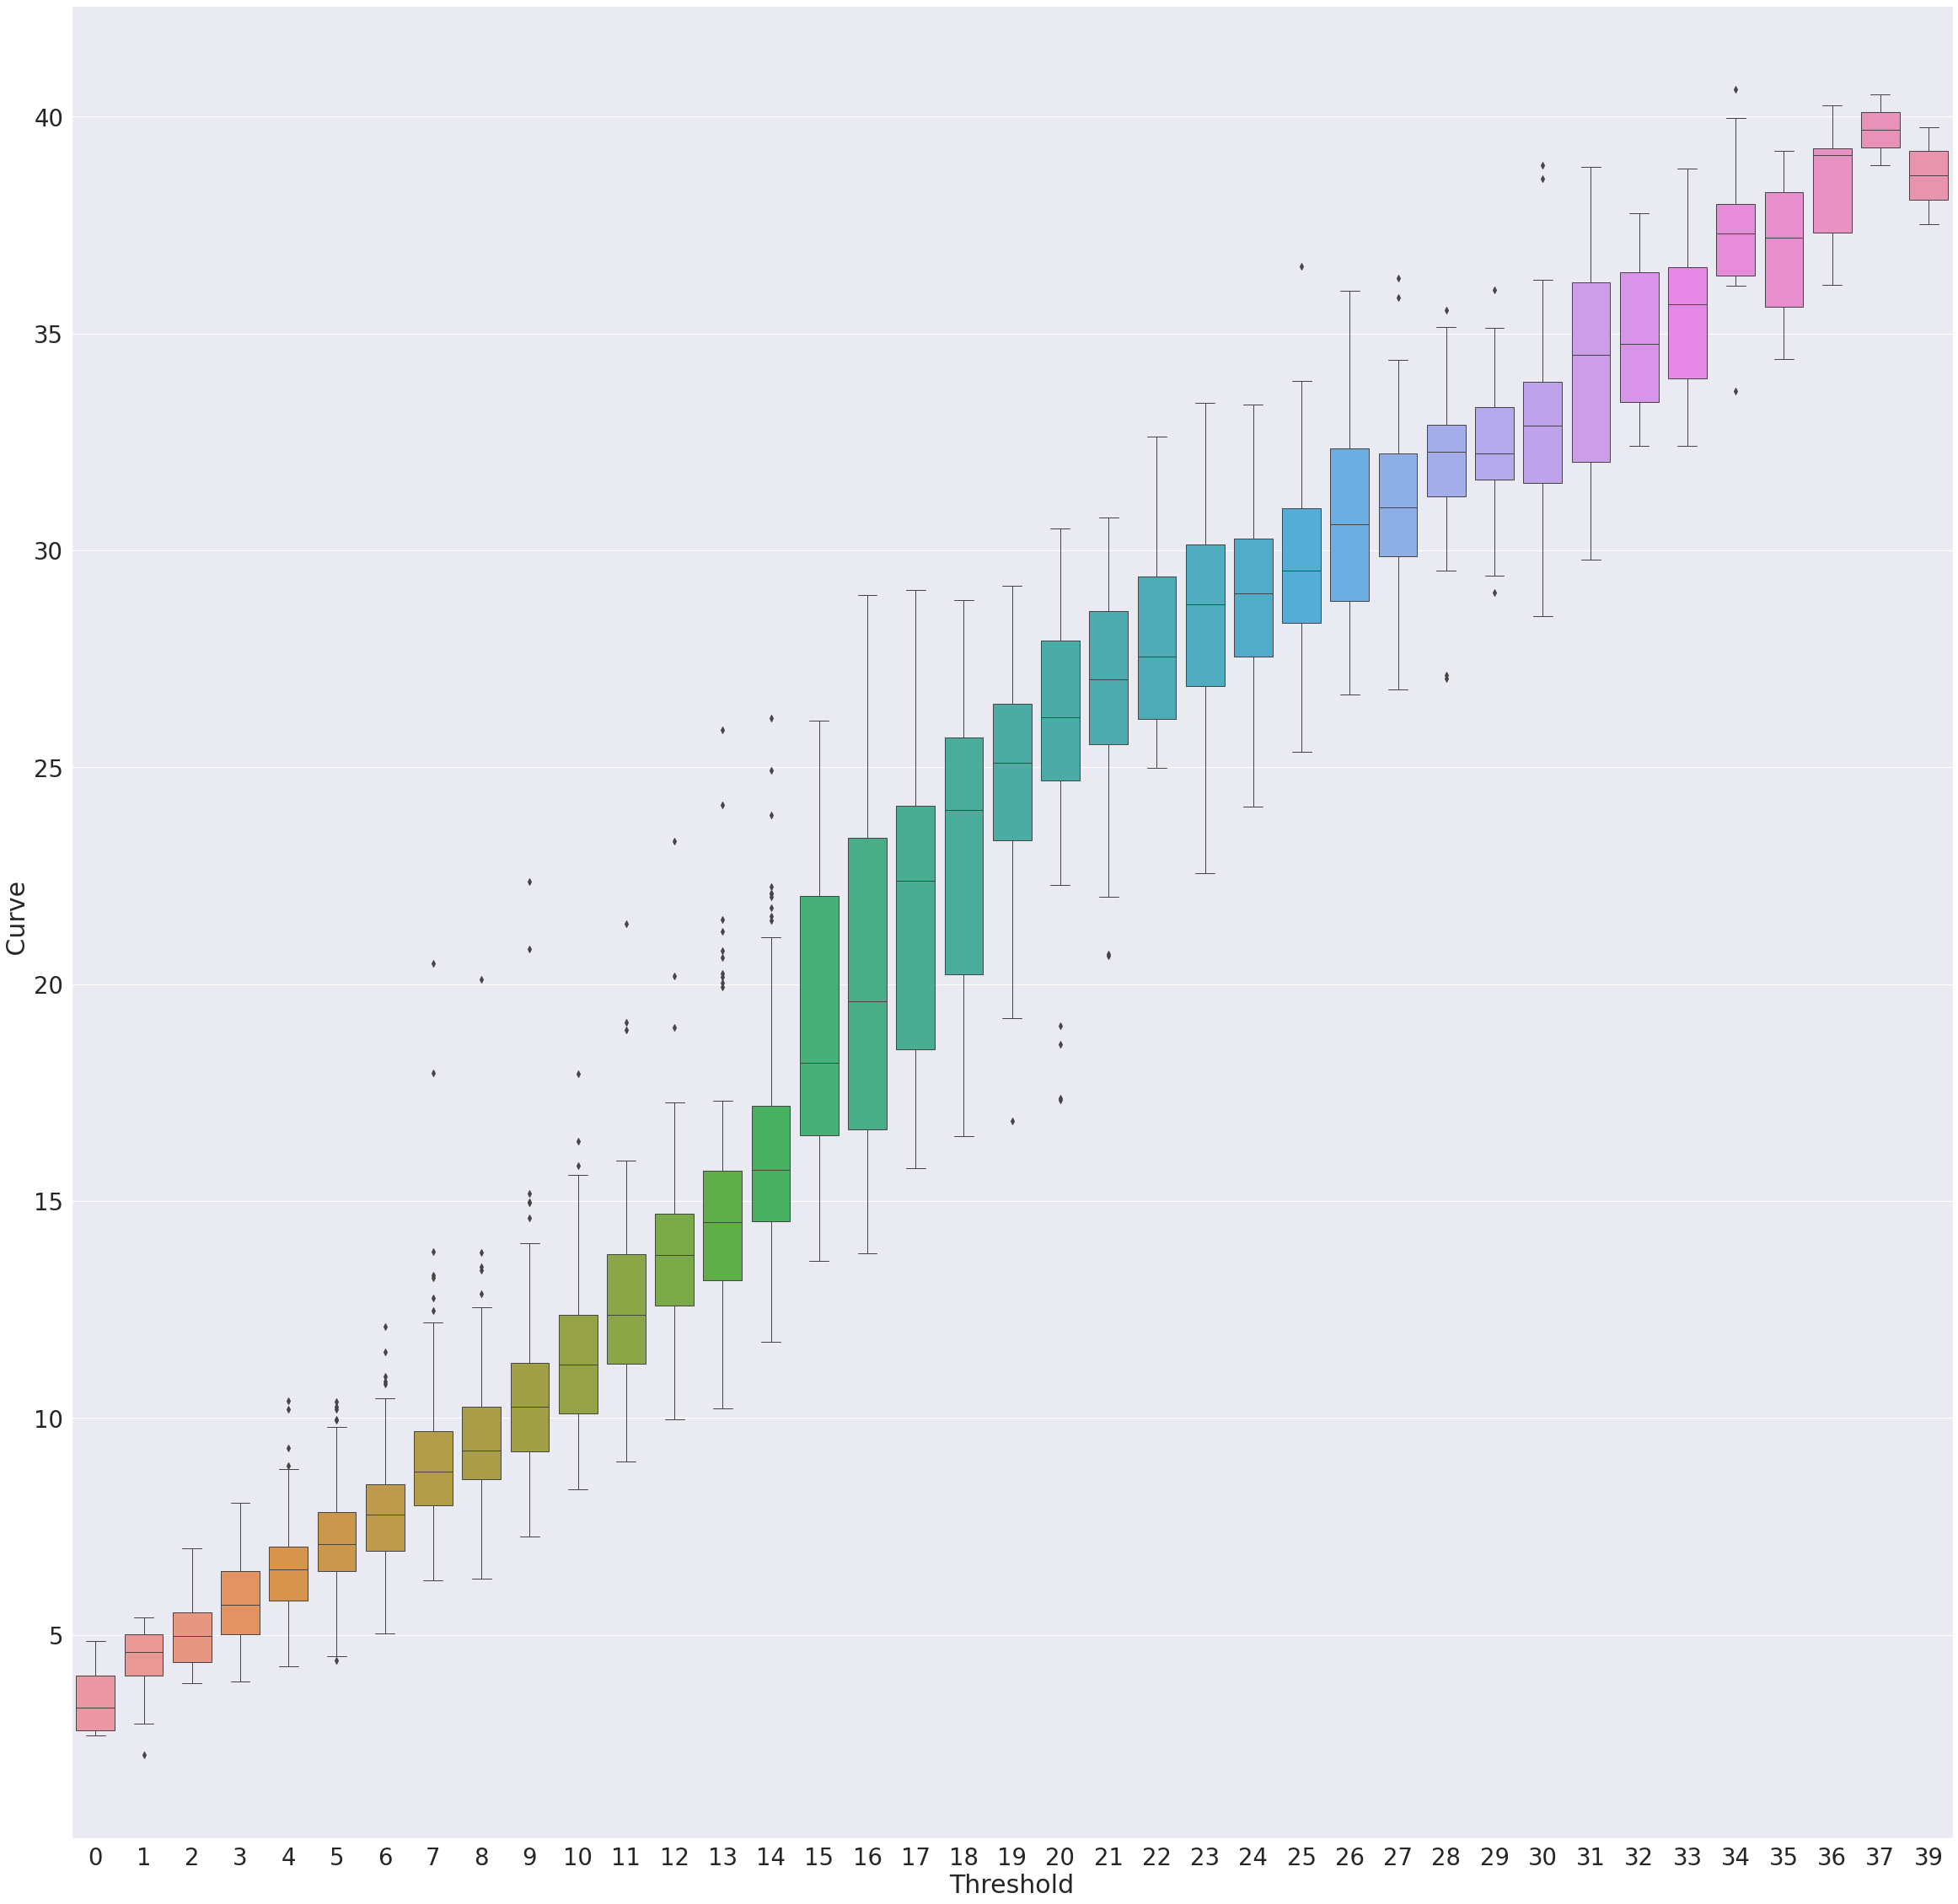

In [23]:
plt.figure(figsize=(40,40))
sns.set_context("notebook", font_scale=2.5, rc={"lines.linewidth": 1})
ax = sns.boxplot(x="Threshold", y=" Curve", data=thr8)

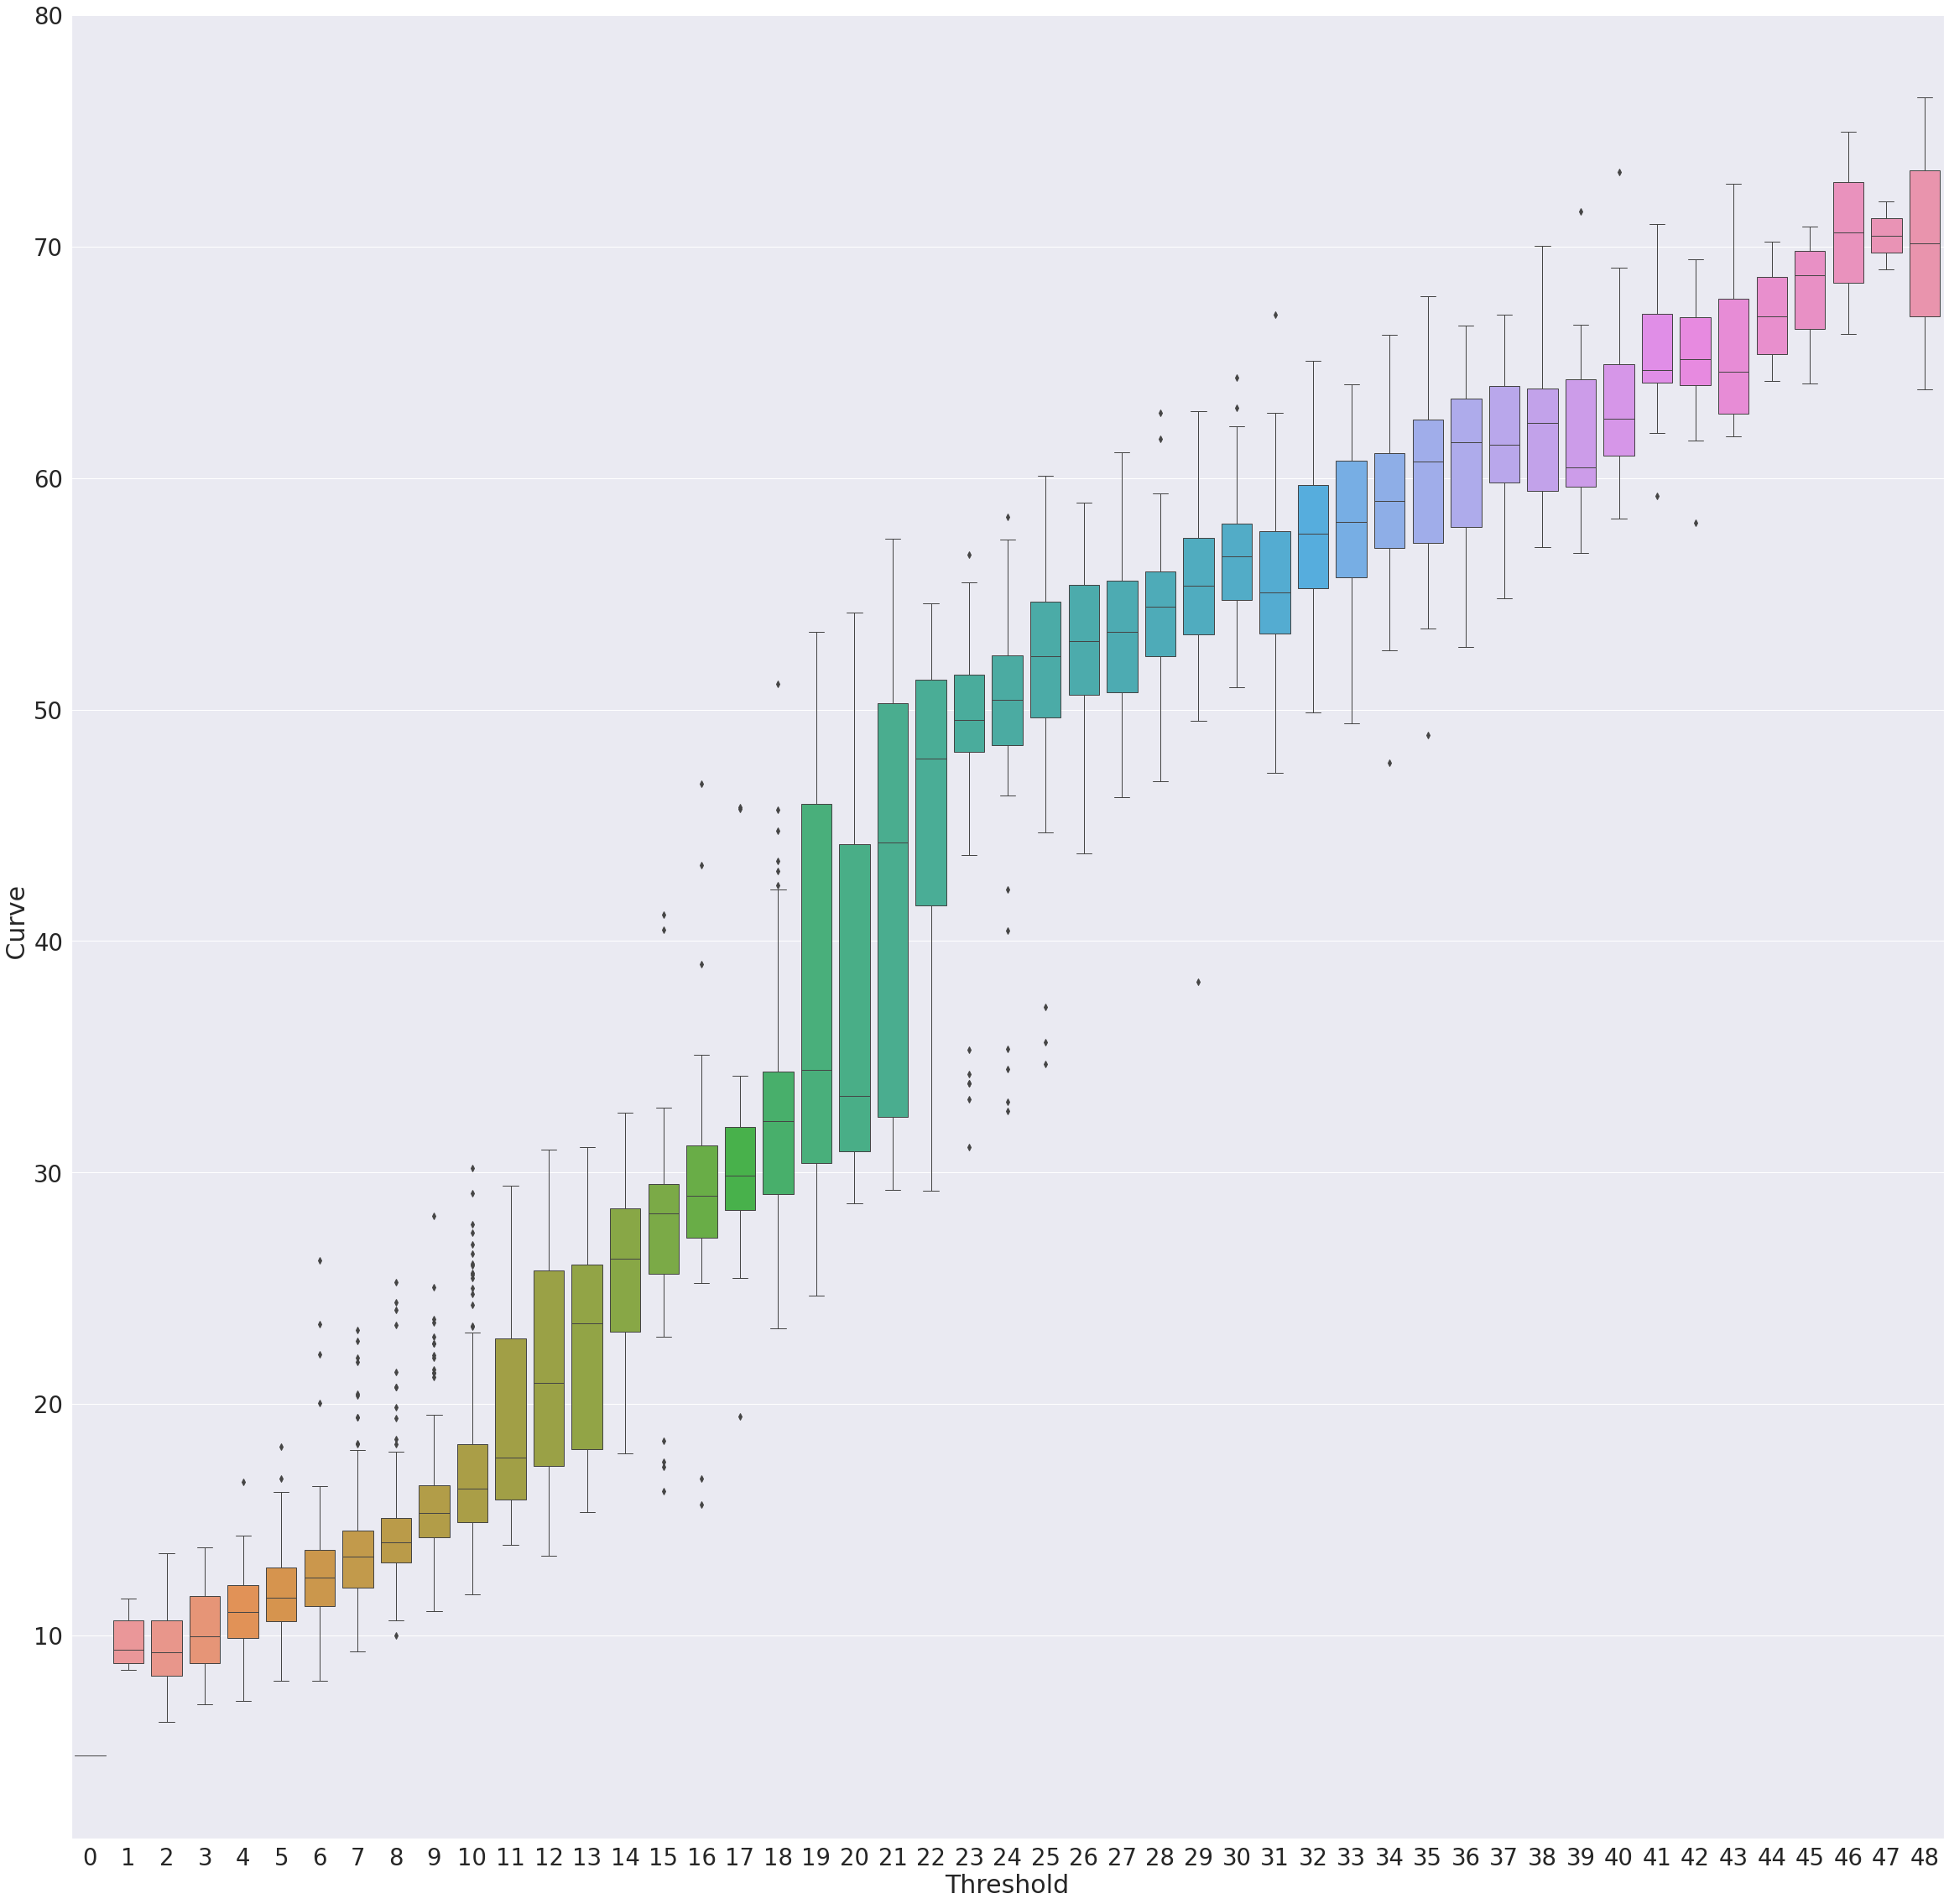

In [24]:
plt.figure(figsize=(40, 40))
sns.set_context("notebook", font_scale=2.5, rc={"lines.linewidth": 1})
ax = sns.boxplot(x="Threshold", y=" Curve", data=thr9)

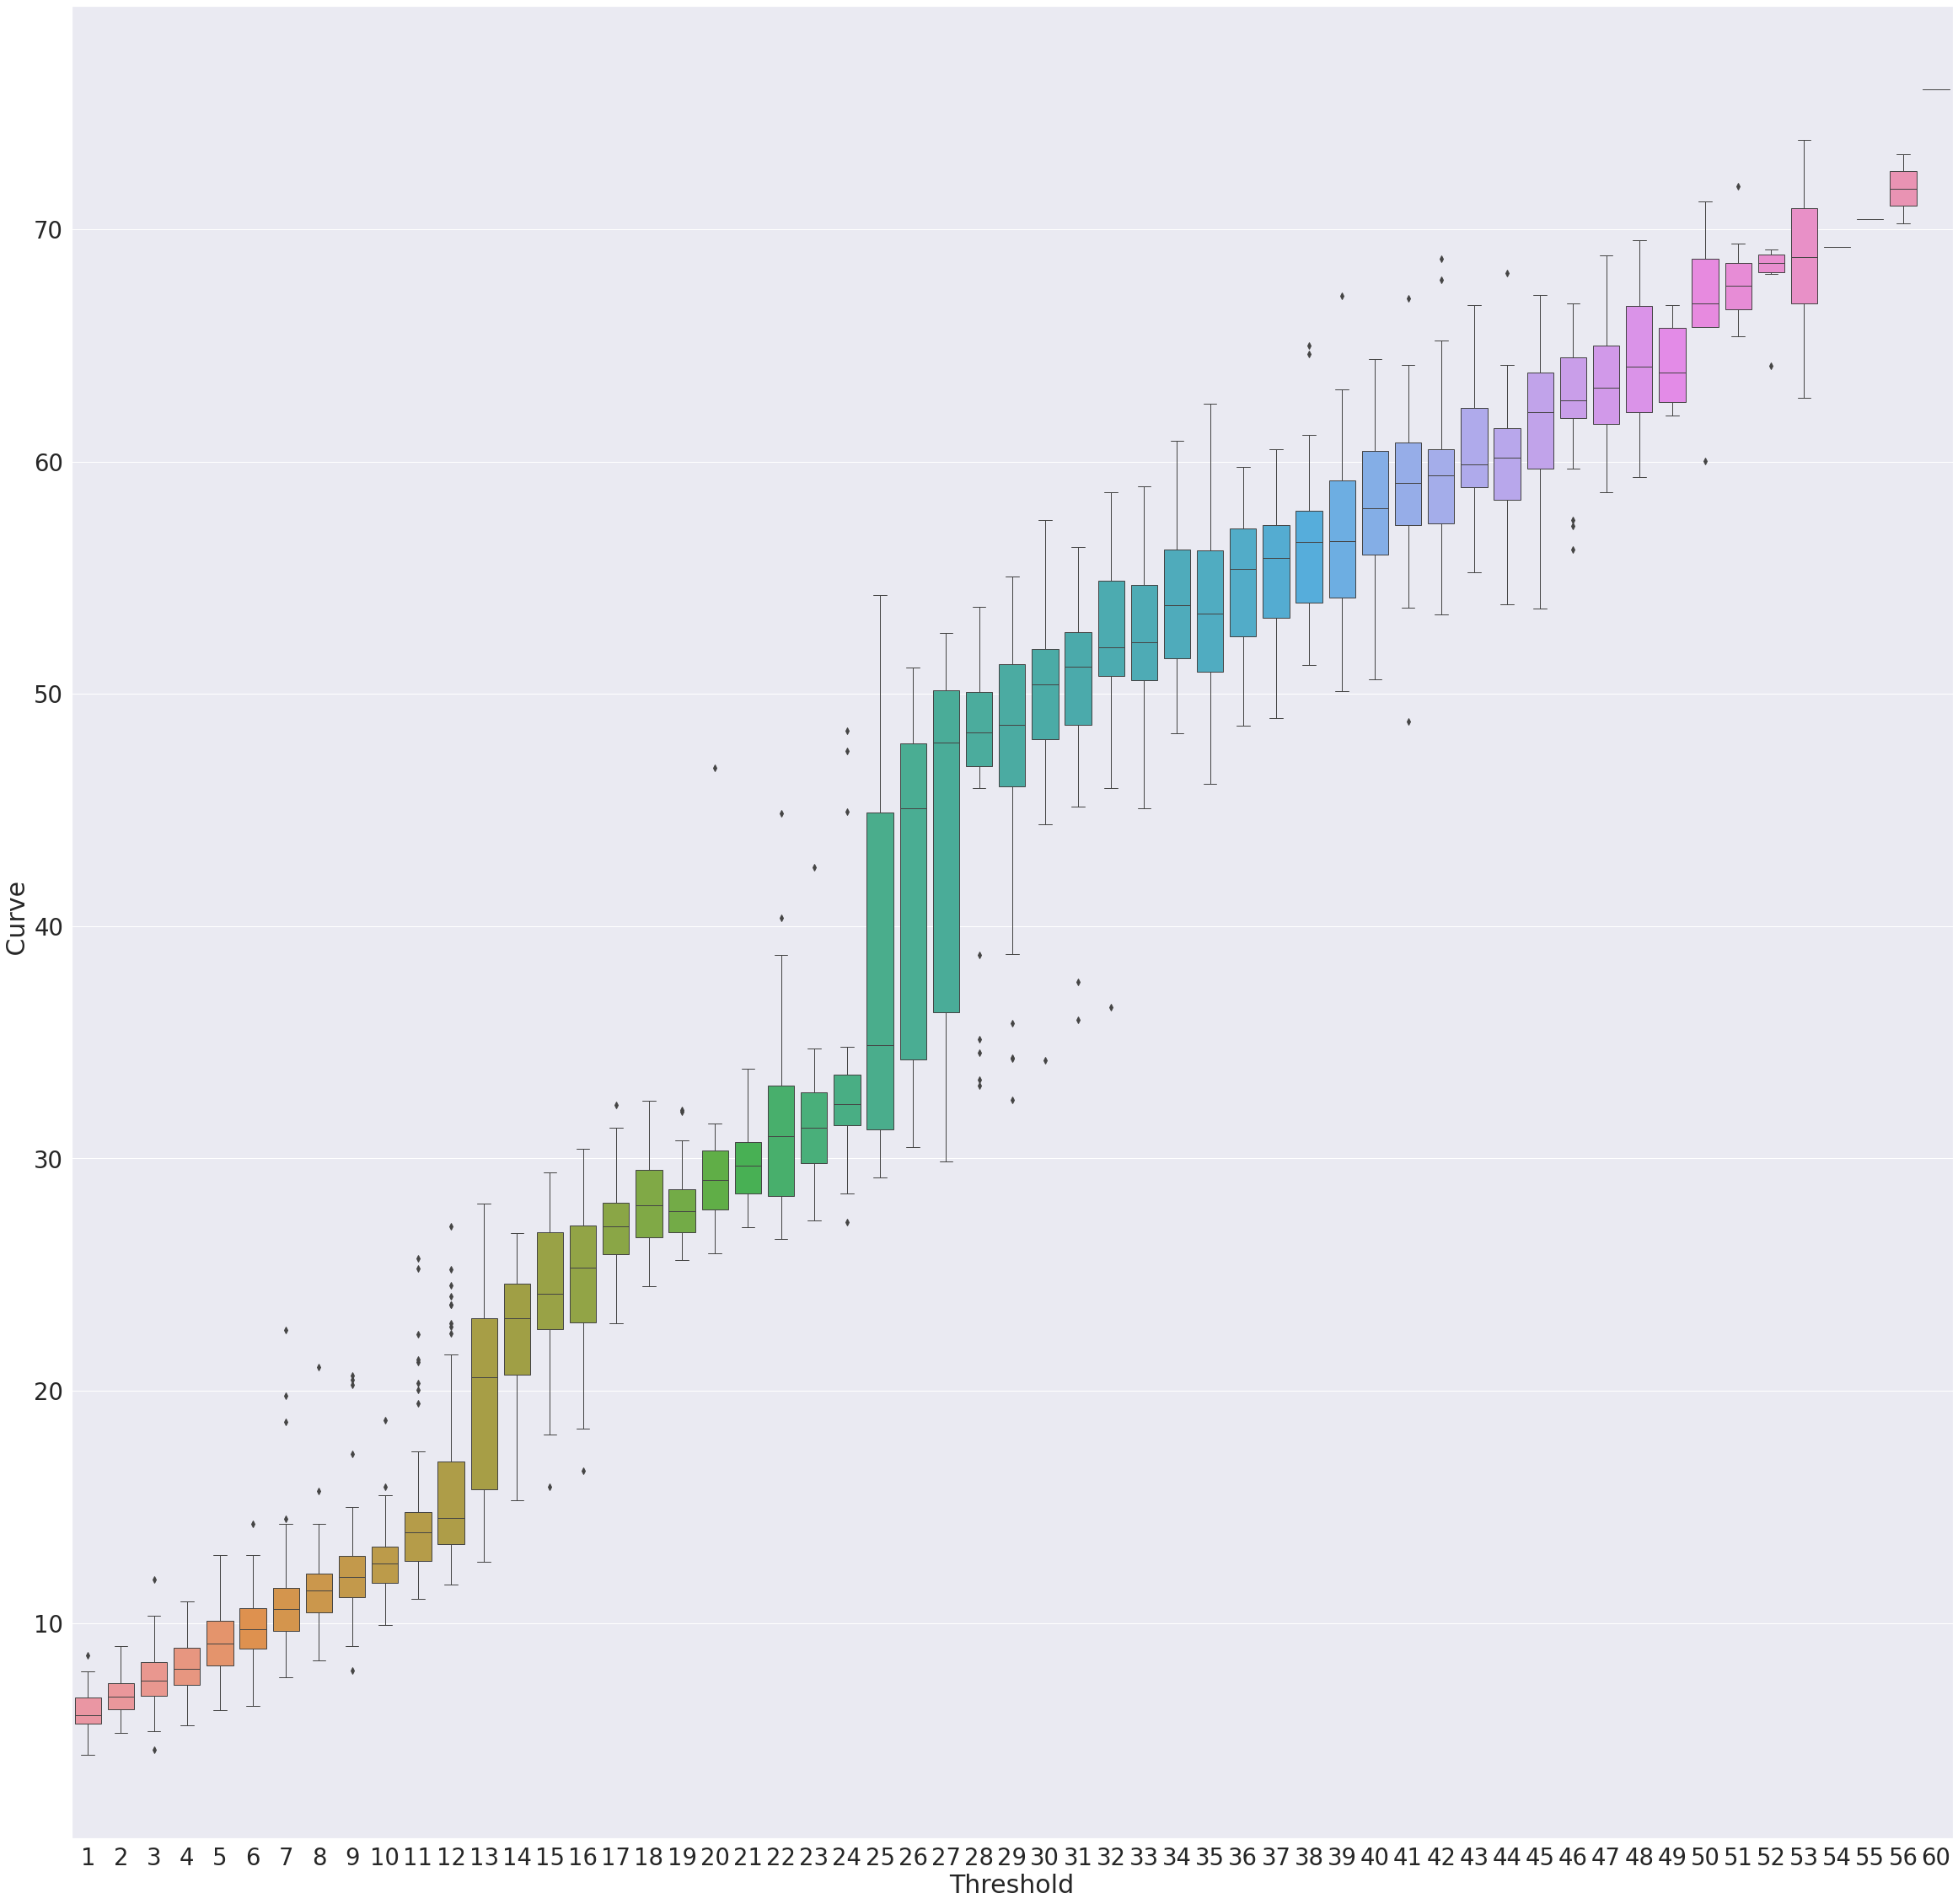

In [25]:
plt.figure(figsize=(40,40))
sns.set_context("notebook", font_scale=2.5, rc={"lines.linewidth": 1})
ax = sns.boxplot(x="Threshold", y=" Curve", data=thr10)